# Прогнозирование заказов такси

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: компания «Чётенькое такси»**

    
**Цель**

Привлечение максимального числа водителей в период пиковой нагрузки.

**Задачи**

- Спрогнозировать количество заказов такси на следующий час.
- Построить модели для такого прогноза.
- Для оценки качества моделей применить метрику RMSE.
- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Описание данных**

Заказчик предоставил исторические данные о заказах такси в аэропортах.

- **Целевой признак:** количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import shap

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
try:
    df = pd.read_csv('M:/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

#### Изучение общей информации о данных

In [4]:
df_info = pd.concat([pd.DataFrame(df.dtypes).rename(columns={0:'Тип данных'}),
                     pd.DataFrame(df.isna().sum()).rename(columns={0:'Количество пропусков'})], axis=1)

df_info['Количество объектов'] = len(df)
display(df_info, df.head(), df.describe().T)

if df.index.is_monotonic:
    print (color.BOLD+color.OKGREEN+'Датасет упорядочен по индексу')
else:
    print (color.BOLD+color.FAIL+'Датасет не упорядочен по индексу')

Тип данных  Количество пропусков  Количество объектов
num_orders      int64                     0                26496

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

count   mean   std   min   25%    50%    75%     max
num_orders 26496.000 14.070 9.211 0.000 8.000 13.000 19.000 119.000

Датасет упорядочен по индексу


In [5]:
def hist_box (df: pd.DataFrame, col: 'name of column', bins: int):    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          gridspec_kw={'height_ratios': (.2, .8)},
                                          figsize=(18,8))
    fig.subplots_adjust(hspace=0.05)
    
    fig.suptitle(f'Распределение значений в признаке {col}', y=.912)
    
    sns.boxplot(x=df[col], ax=ax_box)
    sns.histplot(x=df[col], bins=bins, ax=ax_hist)
    
    ax_box.set(xlabel = '')
    ax_hist.axvline(df[col].mean(),color='orange',linestyle='-')
    ax_hist.axvline(df[col].median(),color='orchid',linestyle='--');
    
    ax_hist.legend(['среднее', 'медиана', 'распределение'],
                   loc='lower center',
                   bbox_to_anchor=[0.5, 0.5]);

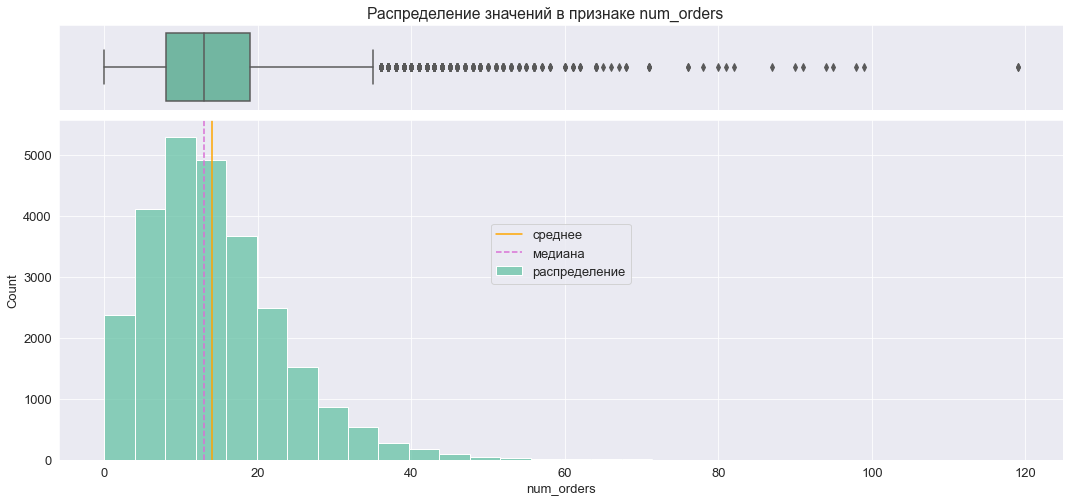

In [6]:
hist_box (df, 'num_orders', bins=30)

- распределение со смещением вправо может отрицательно сказаться на качестве модели

In [7]:
def plot_time (df: pd.DataFrame, col: 'name of column'):
    df.plot(figsize=(18,8),
            title = f'Зависимость признака/группы признаков от даты',
            y = col);

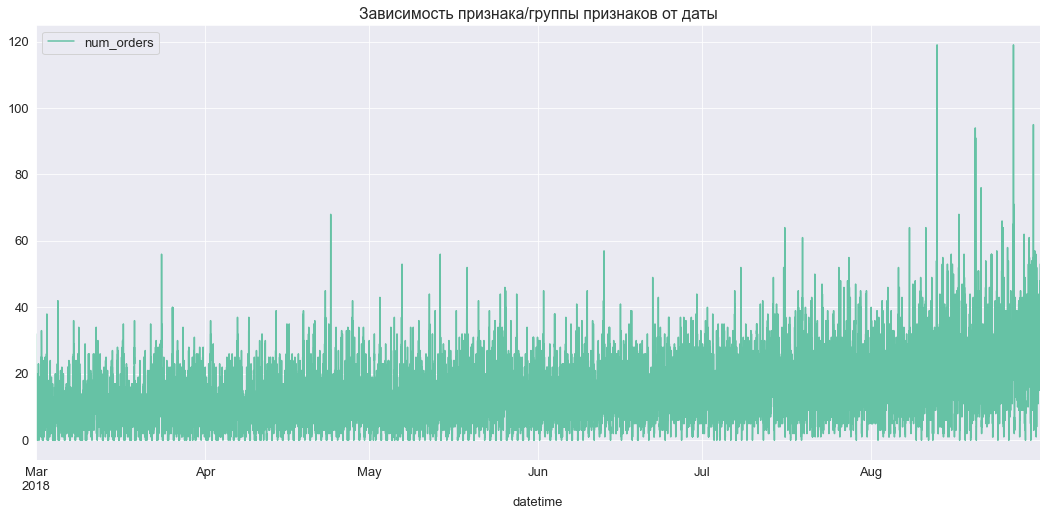

In [8]:
plot_time (df, 'num_orders')

- Наблюдается незначительный рост заказов от месяца к месяцу

#### Ресемплирование по одному часу

Т.к. задача спрогнозировать количество заказов такси на следующий час, увеличим временной интервал до 1 часа.

In [9]:
df = df.resample('1H').sum()
print(color.BOLD+f'Количество объектов в датафрейме: {len(df)}')

Количество объектов в датафрейме: 4416


In [10]:
def hist_box_plot (df: pd.DataFrame, col: 'name of column', bins: int):
    hist_box (df, col, bins)
    plot_time (df, col)

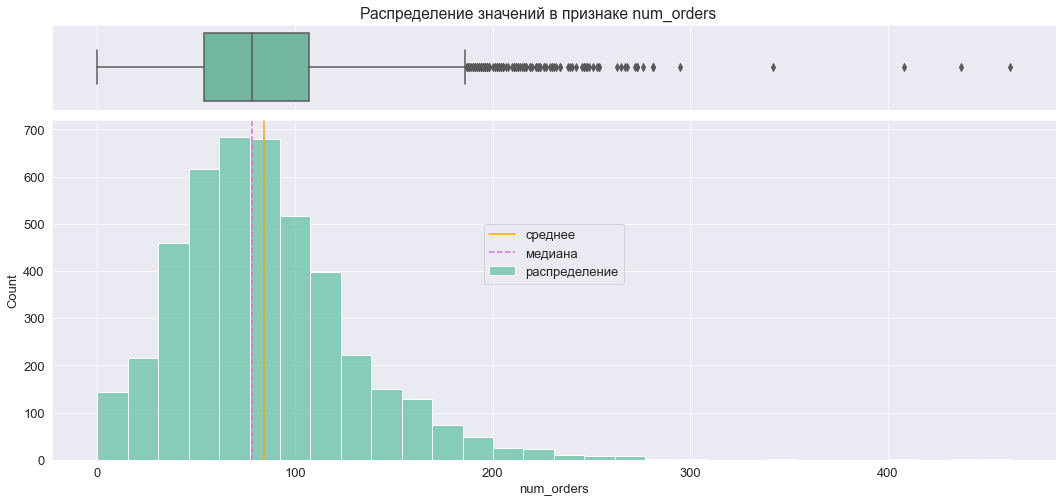

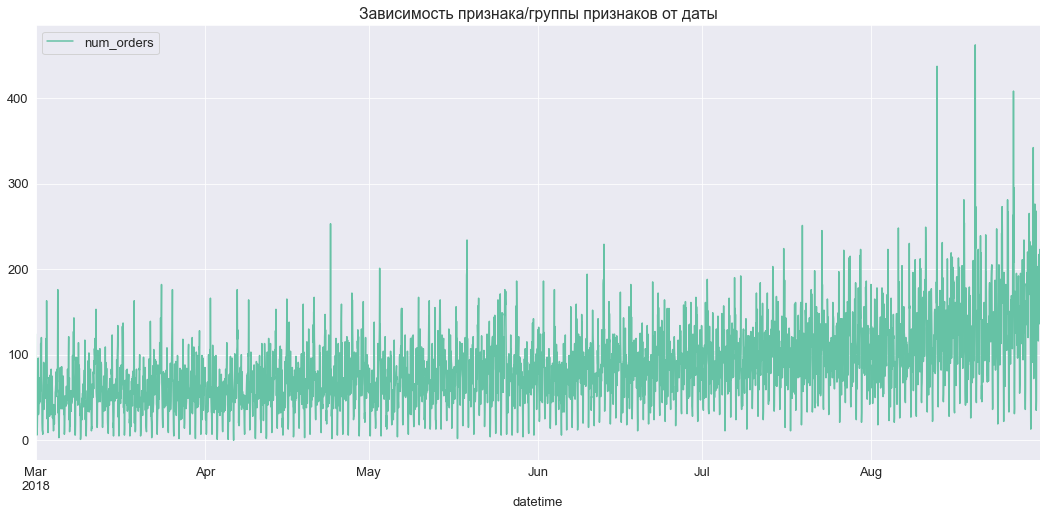

In [11]:
hist_box_plot (df, 'num_orders', bins=30)

- Распределение стало чуть ближе к нормальному, однако смещение вправо осталось, имеются выбивающиеся значения, которые могут отрицательно сказаться качестве модели.

## Анализ временных рядов TSA

### Временной интервал

Определим, в каком временном итервале предоставленны данные

In [12]:
pd.DataFrame({'Дата/время': [df.index.min(), df.index.max()]}, index = ['Начало наблюдения', 'Конец наблюдения'])

Дата/время
Начало наблюдения 2018-03-01 00:00:00
Конец наблюдения  2018-08-31 23:00:00

### Датасет для анализа

Для анализа временных рядов (аббревиатура TSA - Time Series Analysis) сохраним исходный датафрейм в отдельную переменную. 

In [13]:
df_tsa = df.copy()

### Скользящие среднее и стандартное отклонение

Добавим в датасет `df_tsa` столбцы со значениями скользящих среднего и стандартного отклонения.

In [14]:
df_tsa['rolling_mean'] = df_tsa['num_orders'].rolling(40).mean()
df_tsa['rolling_std'] = df_tsa['num_orders'].rolling(40).std()

Сравним значения зависимость скользящих среднего и стандартного отклоненияениями, таргета от даты.

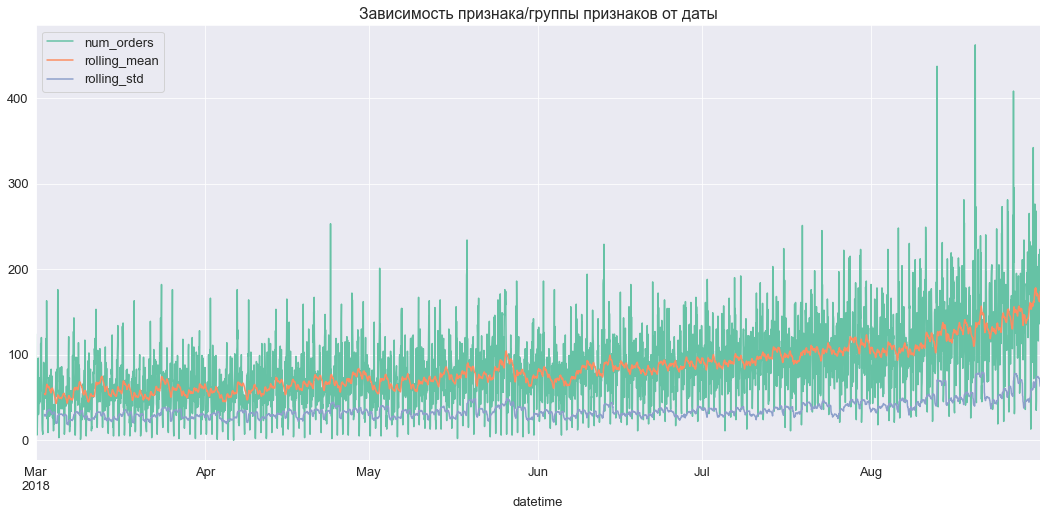

In [15]:
plot_time (df_tsa, ['num_orders', 'rolling_mean', 'rolling_std'])

- Среднее значение и стандартное отклонение меняются - временной ряд нестационарный (англ. nonstationary time series).
- Изменение среднего выражено сильнее в сторону увеличения с каждым месяцем.
- Среднее начинает плавно изменяться с начала мая - тренд из-за сезона отпусков.

### Тренды и сезонности

В модуле `tsa.seasonal` (от англ. time series analysis, «анализ временных рядов») библиотеки `statsmodels` (англ. «статистические модели») есть функция `seasonal_decompose()` (англ. «разбить на части»). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Остаток - компонента, которая не объясняется трендом и сезонностью, это шум.

In [16]:
decomposed = seasonal_decompose(df_tsa['num_orders'])

Функция `seasonal_decompose()` принимает временной ряд, а возвращает объект структуры `DecomposeResult` (англ. «результат разделения»).<br>В нём есть нужные атрибуты:
- `decomposed.trend` — тренд;
- `decomposed.seasonal` — сезонность;
- `decomposed.resid` — остаток.

In [17]:
df_tsa['trend'] = decomposed.trend
df_tsa['seasonal'] = decomposed.seasonal
df_tsa['resid'] = decomposed.resid

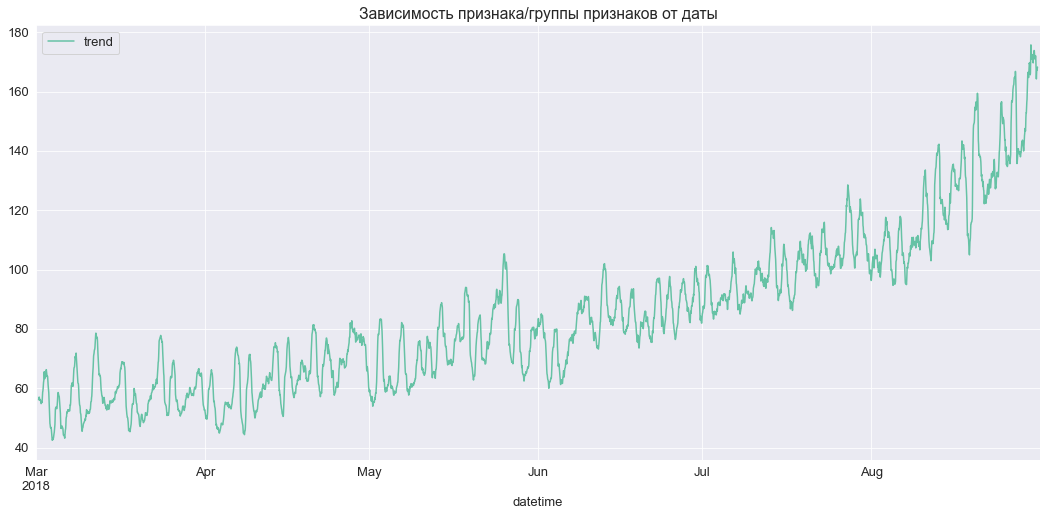

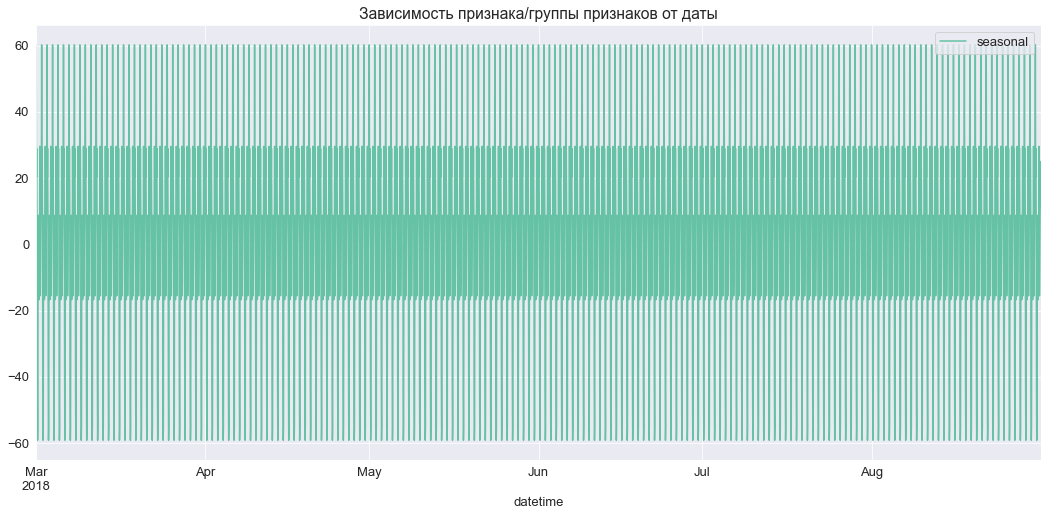

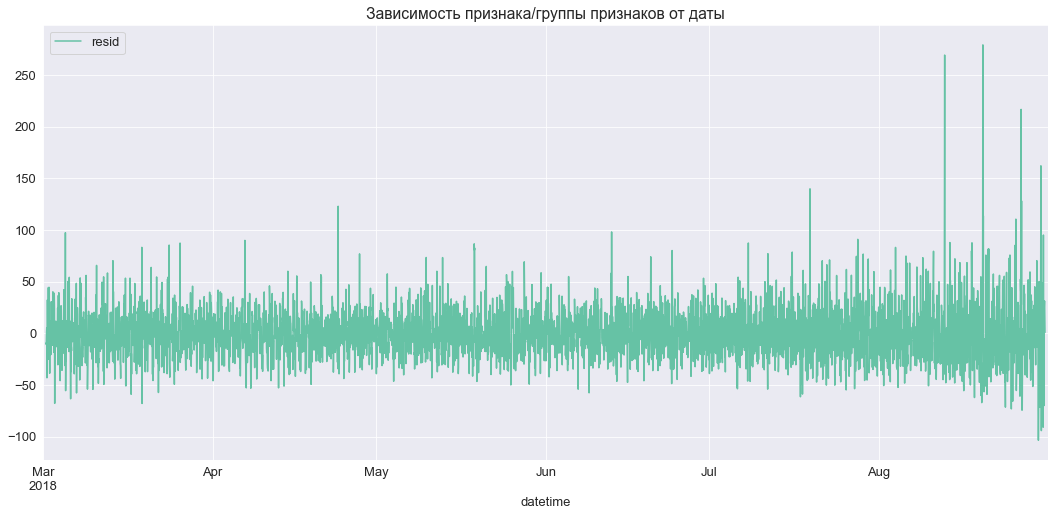

In [18]:
plot_time (df_tsa, 'trend')
plot_time (df_tsa, 'seasonal')
plot_time (df_tsa, 'resid')

- Наблюдения по тренду, сделанные ранее, подтвердились.
- Для изучения сезонности нужно рассмотреть график на более коротком временном интервале.
- Также в данных имеется немало шума.

Для изучения сезонности сделаем несколько срезов.

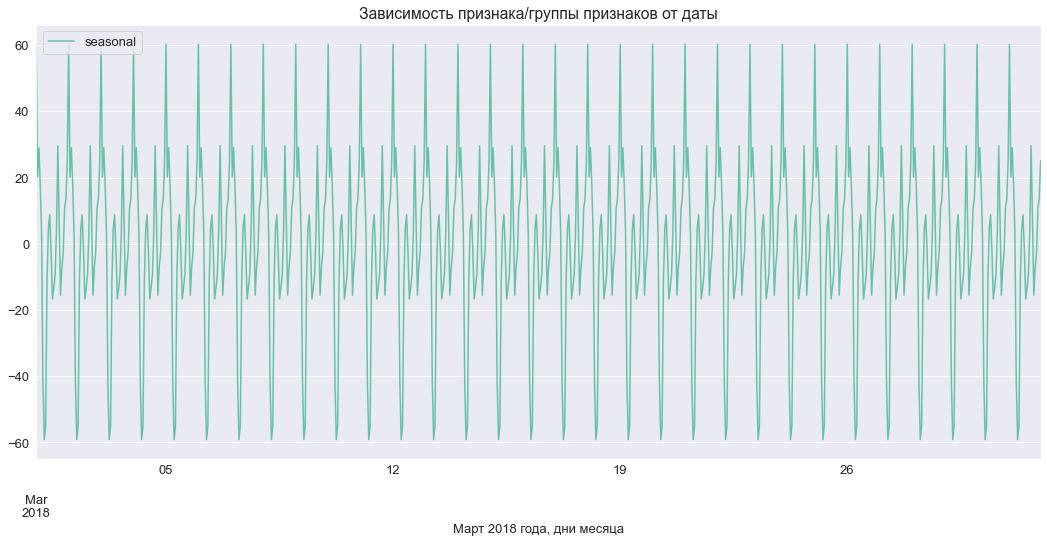

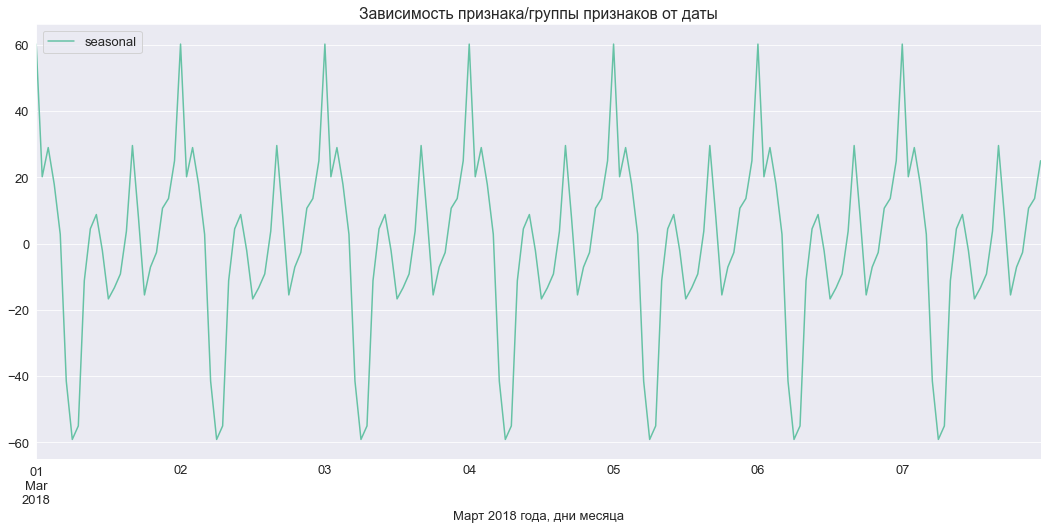

In [19]:
plot_time (df_tsa['2018-03-01':'2018-03-31'], 'seasonal')
plt.xlabel('Март 2018 года, дни месяца')
plt.legend(loc='upper left')
plot_time (df_tsa['2018-03-01':'2018-03-07'], 'seasonal')
plt.xlabel('Март 2018 года, дни месяца')
plt.legend(loc='upper left');

Сезонность равна одному дню.

Дополнительно изучим изменение значений сезонности в течение дня, к примеру, 17 марта.

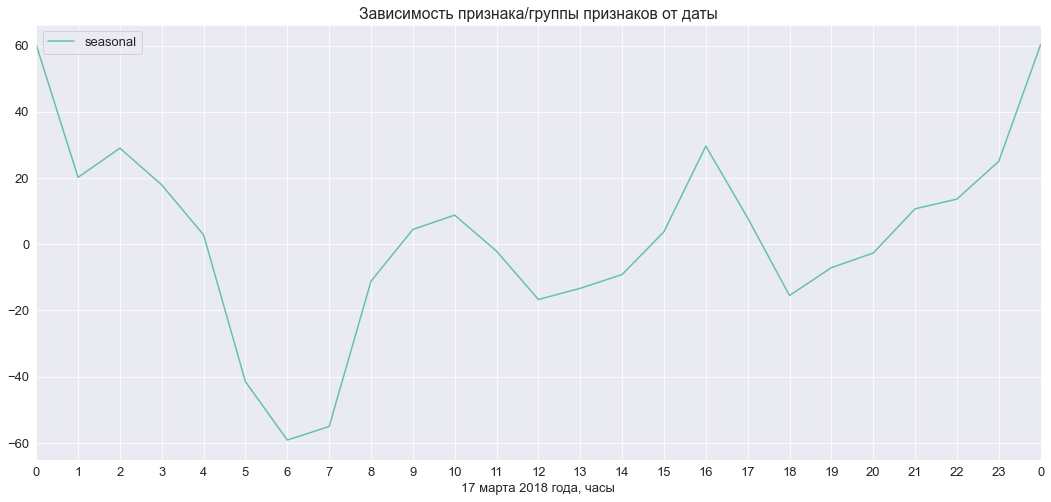

In [20]:
plot_time (df_tsa['2018-03-17 00:00:00':'2018-03-18 00:00:00'], 'seasonal')
plt.xticks(ticks = df_tsa['2018-03-17 00:00:00':'2018-03-18 00:00:00'].index,
           labels = df_tsa['2018-03-17 00:00:00':'2018-03-18 00:00:00'].index.hour,
           rotation=0)
plt.xlabel('17 марта 2018 года, часы')
plt.legend(loc='upper left');

- максимальное количество заказов в 00:00
- с 00:00 до 06:00 количество заказов падает
- с 06:00 до 10:00 количество заказов растет
- в обеденное время количество заказов падает и растет к 16:00
- с 16:00 до 18:00 количество заказов падает и далее растет до 00:00 следующего дня

Т.к. сезонность присутсвует и ярко выражена, в дальнейшем добавим её значения в признаки для машинного обучения.

### Исследование стационарности ряда

Ранее выяснилось, что временной ряд в исходных данных нестационарный (распределение среднего меняется).<br>
Нестационарные ряды прогнозировать сложнее стационарных, их свойства меняются слишком быстро.<br>
Чтобы ряд сделать стационарным, найдём разности его значений, используя метод shift() (англ. «сдвиг»).<br>
Разности временного ряда более стационарны, чем сам ряд.

In [21]:
df_shift = df - df.shift()

In [22]:
df_shift = df - df.shift()
df_shift['rolling_mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['rolling_std'] = df_shift['num_orders'].rolling(15).std()

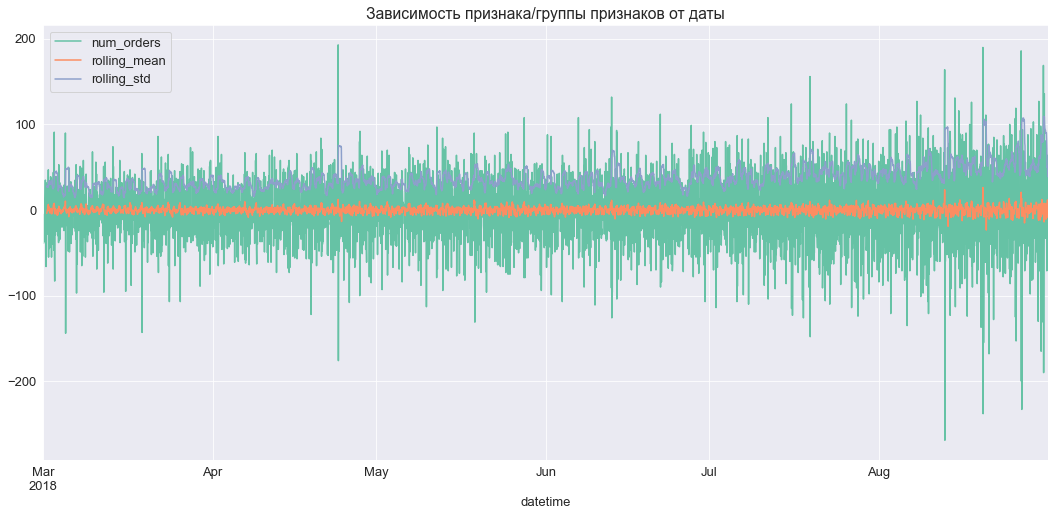

In [23]:
plot_time (df_shift, ['num_orders', 'rolling_mean', 'rolling_std'])

При добавлении сдвига ряд стал более стационарным, разпределение значений скользящего среднего не меняется со временем, что подтверждено графически, в дальнейшем добавим значением скользящего среднего со сдвигом в признаки для машинного обучения.

Переходим к машинному обучению.

## Машинное обучение

### Функция для вычисления метрики RMSE

По исходным данным для оценки качества моделей требуется вычислить метрику `RMSE`, значение `RMSE` должно быть меньше `2500`.

`RMSE` *(англ. root mean squared error, «корень из средней квадратичной ошибки»)* показывает, как сильно правильный ответ отличается от предсказания.

Формула расчёта `RMSE` выглядит так: $RMSE=\sqrt[]{{\frac 1N}{\sum_{i=1}^N(предсказание\,модели-правильный\,ответ)^2}}$

*Величина `RMSE` должна быть как можно меньше.*

Создадим функцию для вычисления метрики RMSE и сохраним в отдельную переменную оценку работы функции для дальнейшего подбора гиперпараметров.

In [24]:
def rmse_score(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

### Сохранение максимального RMSE

Согласно исходным данным значение метрики RMSE на тестовой выборке должно быть не больше 48.<br>Сохраним это значение в отдельную переменную.

In [25]:
rmse_max = 48

### Формирование признаков

Для подбора оптимальных значений признаков создадим функцию `features_choice()`.

На входе функции:
- `df` - датафрейм,
- `max_lag` - максимальный размер отставания для отстающих значений,
- `rolling_mean_size` - ширину окна для скользящего среднего.

На выходе функции:
- `df_ml` - датафрейм для машинного обучения

In [26]:
def features_choice(df, max_lag, rolling_mean_size):
    
    '''Сохранение датасета для машинного обучения в отдельную переменную'''
    
    df_ml=df.copy()
    
    '''Формирование признаков'''
    
    df_ml['dayofweek'] = df_ml.index.dayofweek                                            # день недели
    df_ml['day'] = df_ml.index.day                                                        # день
    df_ml['month'] = df_ml.index.month                                                    # месяц
    df_ml['seasonal'] = df_tsa['seasonal']                                                # сезонность

    for lag in range(4, max_lag + 1):
        df_ml[f'lag_{lag}'] = df_ml['num_orders'].shift(lag)                              # отстающие значения
    
    df_ml['rolling_mean'] = df_ml['num_orders'].shift().rolling(rolling_mean_size).mean() # cкользящее среднее
    
    return df_ml

In [27]:
df_ml = features_choice(df, 6, 1)

In [28]:
pd.DataFrame(df_ml.isna().sum()).rename(columns={0:'Количество пропусков'})

Количество пропусков
num_orders                       0
dayofweek                        0
day                              0
month                            0
seasonal                         0
lag_4                            4
lag_5                            5
lag_6                            6
rolling_mean                     1

- В созданном для обучения датасете появились пропуски, которые необходимо удалить.

### Удаление пропусков

In [29]:
df_ml = df_ml.dropna()
pd.DataFrame(df_ml.isna().sum()).rename(columns={0:'Количество пропусков'})

Количество пропусков
num_orders                       0
dayofweek                        0
day                              0
month                            0
seasonal                         0
lag_4                            0
lag_5                            0
lag_6                            0
rolling_mean                     0

### Функция создания переменных для фичей и таргета, деление на выборки

Создадим функцию `split_data()`, на вход которой подаётся:
- `df` - датафрейм для соответствующей модели.

На выходе функции:
- `target` - целевой признак,
- `target_train` - целевой признак обучающей выборки,
- `target_valid` - целевой признак вылидационной выборки,
- `target_test` - целевой признак тестовой выборки,
- `features` - признаки,
- `features_train` - признаки обучающей выборки,
- `features_valid` - признаки вылидационной выборки,
- `features_test` - - признаки тестовой выборки.

In [30]:
def split_data (df: pd.DataFrame):
    
    '''Создание переменных для признаков и целевого признака'''
    
    target = df['num_orders']
    features = df.drop('num_orders', axis=1)
    
    '''Деление данных на выборки'''
    
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  shuffle=False,
                                                                                  test_size=.2,
                                                                                  random_state=42)
    features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                                target_valid,
                                                                                shuffle=False,
                                                                                test_size=.5,
                                                                                random_state=42)
    
    print(color.BOLD+color.UNDERLINE+'Проверка результатов деления на выборки'+color.END)
    
    display (pd.DataFrame({'train': [target_train.index.min(), target_train.index.max(), len(target_train)],
                           'valid': [target_valid.index.min(), target_valid.index.max(), len(target_valid)],
                           'test' : [target_test.index.min(), target_test.index.max(), len(target_test)]},
                           index = ['Время начала наблюдения', 'Время конца наблюдения', 'Размер выборки']))
    
    '''Визуализация процентного соотношения размеров выборок'''
    
    selections = pd.Series({'обучающая': len(target_train),
                            'валидационная': len(target_valid),
                            'тестовая': len(target_test)})
    
    fig = plt.figure(figsize=(10, 4))

    pie_selections=selections.plot(kind='pie',
                                   label='',
                                   autopct='%1.0f%%',
                                   title='Соотношение\nразмеров выборок',
                                   shadow=True,
                                   wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                   colors = ['lightseagreen', 'hotpink', 'gold'],
                                   fontsize=13)
    pie_selections.title.set_size(15)  
    
    return target, target_train, target_valid, target_test, features, features_train, features_valid, features_test

### Линейные модели

#### Создание переменных для фичей и таргета, деление на выборки

Проверка результатов деления на выборки


train                valid  \
Время начала наблюдения  2018-03-01 06:00:00  2018-07-26 06:00:00   
Время конца наблюдения   2018-07-26 05:00:00  2018-08-13 14:00:00   
Размер выборки                          3528                  441   

                                        test  
Время начала наблюдения  2018-08-13 15:00:00  
Время конца наблюдения   2018-08-31 23:00:00  
Размер выборки                           441

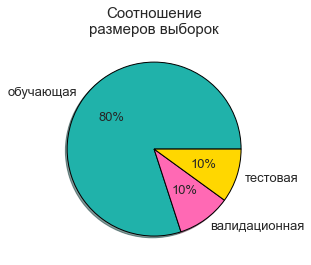

In [31]:
(target_line,
 target_train_line,
 target_valid_line,
 target_test_line,
 features_line,
 features_train_line,
 features_valid_line,
 features_test_line) = split_data (df_ml)

#### Масштабирование признаков 

##### Проверка масштаба

Для начала убедимся, что у признаков разный масштаб графически на точечной диаграмме.

Напишем функцию `scaling_plot()`, т.к. действие будет повторяться.
- На вход фунция принимает признаки обучающей, валидационной и тестовой выборок.
- На выходе ничего не возвращает, служит для визуализации разброса значений объектов по признакам.

In [32]:
def scaling_plot(features_train, features_valid, features_test):    
    selection = [features_train, features_valid, features_test]
    title = ['Разброс значений объектов по признакам для обучающей выборки',
             'Разброс значений объектов по признакам для валидационной выборки',
             'Разброс значений объектов по признакам для тестовой выборки']
    
    for i in range(3):
    
        fig, ax = plt.subplots(figsize=(20,5)) 
        
        for column in list(selection[i].columns):
            ax.scatter([column]*len(selection[i]), selection[i][column], alpha=.5, linewidth=7, s = 1)
        
        ax.set_xlabel('Признаки', fontsize=15)
        ax.set_ylabel('Объекты', fontsize=15)
        plt.title(title[i], fontsize=15, y=1.03)
        plt.xticks(rotation = 90)
        plt.rcParams['font.size'] = '13'
        plt.show()

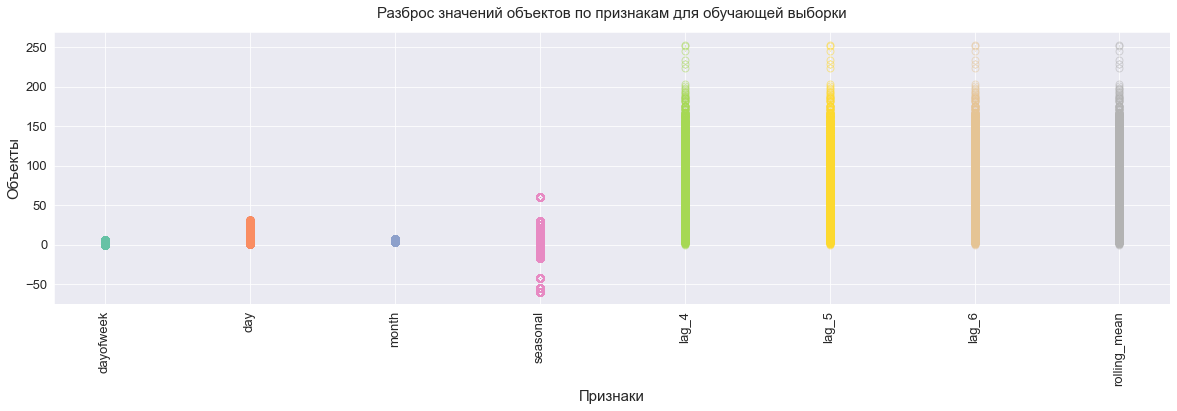

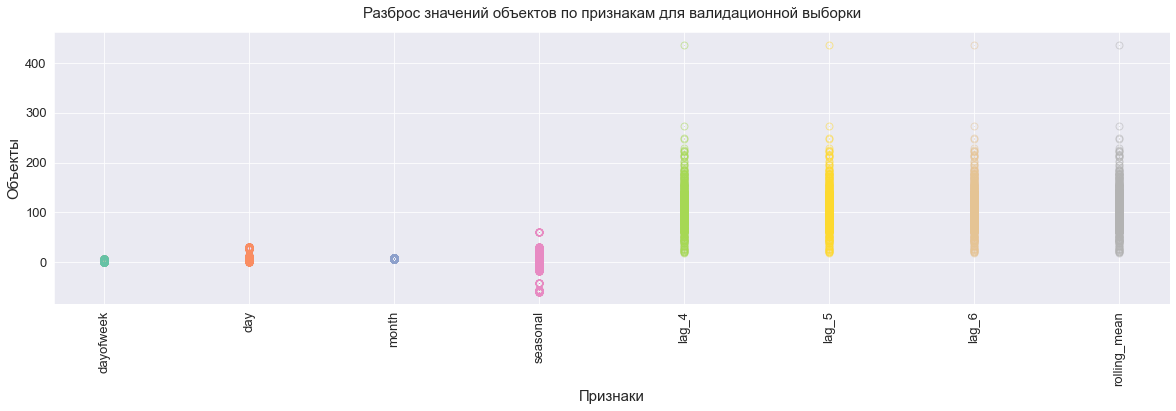

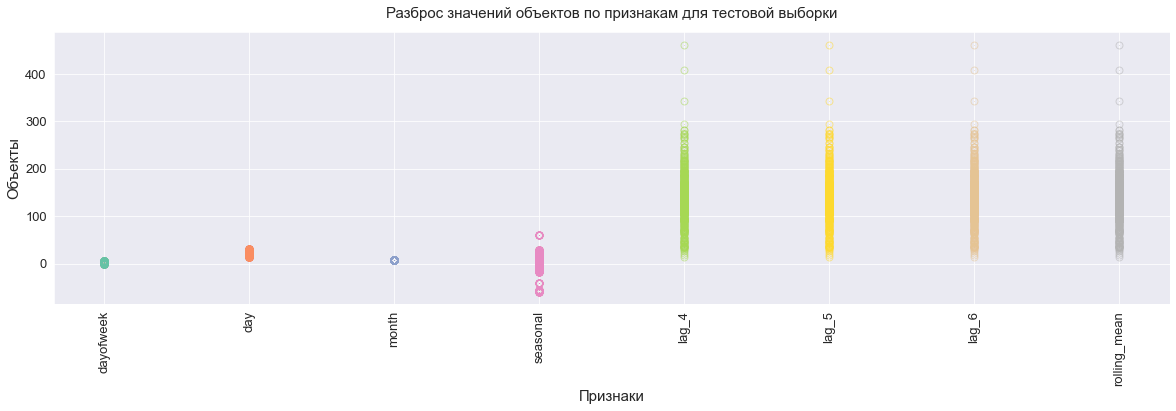

In [33]:
scaling_plot (features_train_line, features_valid_line, features_test_line)

Т.к. у признаков разный масштаб, для линейных моделей необходимо их стандартизировать - привести к одному масштабу.

##### Масштабирование

Выполним масштабирование признаков.

In [34]:
numeric = list(features_line.columns)

scaler = StandardScaler()
scaler.fit(features_train_line[numeric])
features_train_line[numeric] = scaler.transform(features_train_line[numeric])
features_valid_line[numeric] = scaler.transform(features_valid_line[numeric])
features_test_line[numeric] = scaler.transform(features_test_line[numeric])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### Проверка результатов масштабирования

Проверим результаты масштабирования на точечной диаграмме.

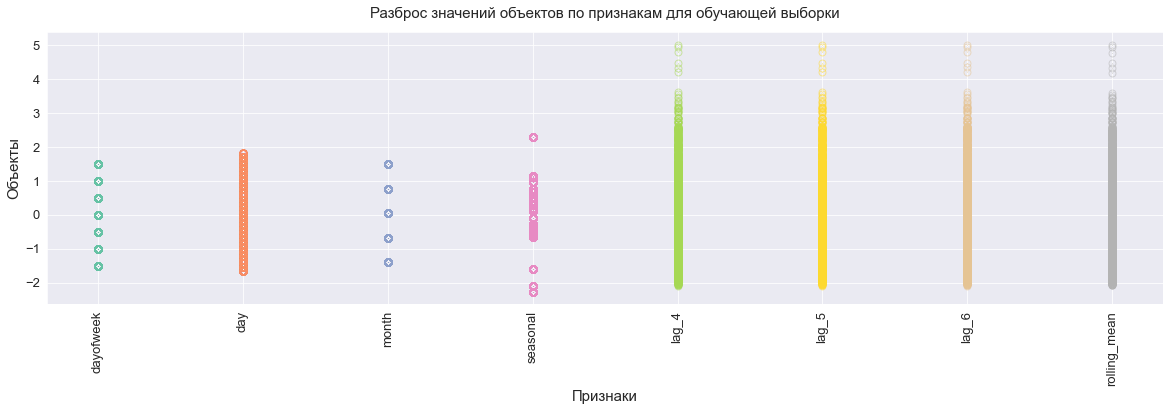

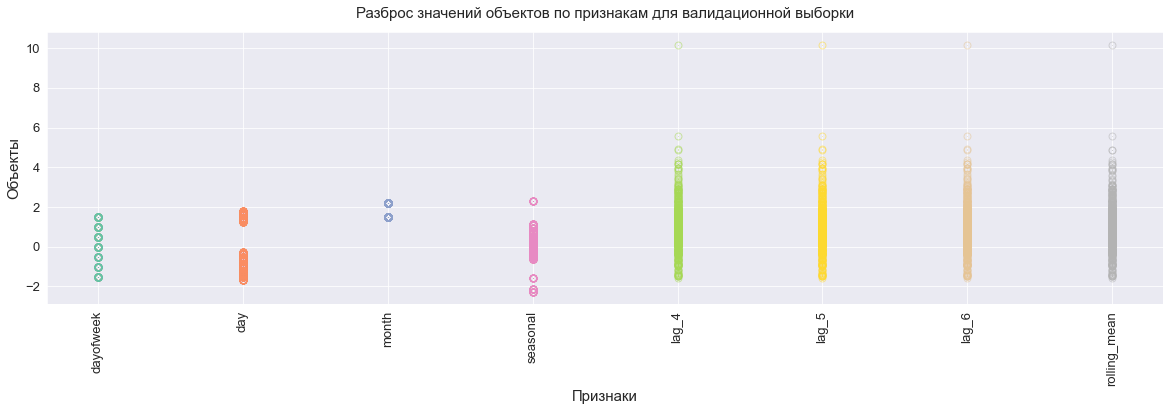

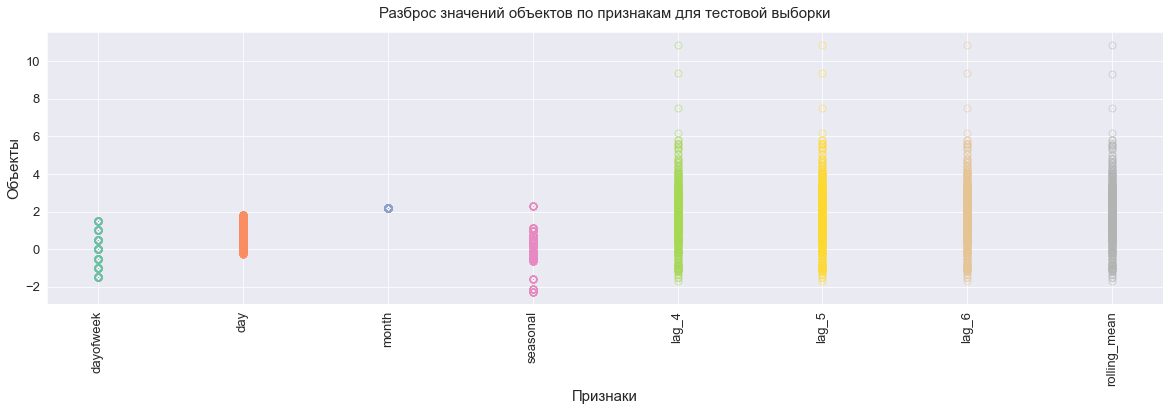

In [35]:
scaling_plot (features_train_line, features_valid_line, features_test_line)

Признаки приведены к одному масштабу.

#### Функция обучения, предсказаний и получения метрик модели

Cоздадим функцию `model_metrics()`.

На входе функции:
- `model` - модель регрессии
- `target_train` - целевой признак обучающей выборки
- `target_test` - целевой признак тестовой (или валидационной) выборки
- `features_train` - признаки обучающей выборки
- `features_test` - признаки тестовой (или валидационной) выборки

На выходе функции:
- `model` - модель
- `metrics` - датафрейм с метриками модели

Датафрейм `metrics`:
- `model` - модель     
- `rmse` - значение метрики RMSE для выбранной модели      
- `rmse_base` - значение метрики RMSE для базовой (константной) модели   
- `rmse_max` - предельное значение метрики RMSE согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели

In [36]:
def model_metrics(model: 'ModelRegressor',
                  target_train: pd.Series,
                  target_valid: pd.Series,
                  features_train: pd.DataFrame,
                  features_valid: pd.DataFrame):
    
    '''Обучение, предсказания модели, вычисление времени кода'''
    
    start_fit = time.time()
    model.fit(features_train, target_train)                                      # обучение модели
    time_fit = time.time() - start_fit                                           # время обучения модели
    
    start_pred = time.time()
    predictions = model.predict(features_valid)                                  # предсказания модели
    time_pred = time.time() - start_pred                                         # время предсказания модели
    
    rmse = rmse_score(target_valid, predictions)                                 # вычисление RMSE      
        
    '''Baseline'''   
   
    predictions_base = target_valid.shift(fill_value=int(target_train.iloc[-1])) # предсказания предыдущим значением ряда
    rmse_base = rmse_score(target_valid, predictions_base)                       # вычисление RMSE
    
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'     : [model],
                            'rmse'      : [rmse],
                            'rmse_base' : [rmse_base],
                            'rmse_max'  : [rmse_max],
                            'sanity'    : [rmse < rmse_base],
                            'quality'   : [rmse < rmse_max],
                            'time_fit'  : [time_fit],
                            'time_pred' : [time_pred]})   
    
    display(metrics)
    
    if rmse < rmse_base:
        print(color.OKGREEN+color.BOLD+'Качество лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество уступает базовому уровню, модель невменяема.'+color.END)
    
    if rmse < rmse_max:
        print(color.OKGREEN+color.BOLD+'Качество лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество уступает предельному по исходным данным.'+color.END)    
    
    return model, metrics

#### Линейная регрессия

In [37]:
model_line, metrics_line = model_metrics(LinearRegression(),
                                         target_train_line,
                                         target_valid_line,
                                         features_train_line,
                                         features_valid_line)

model   rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LinearRegression() 32.563     47.249        48    True     True     0.003   

   time_pred  
0      0.001

Качество лучше базового уровня, модель вменяема.
Качество лучше предельного по исходным данным.


#### Гребневая регрессия

In [38]:
model_ridge, metrics_ridge = model_metrics(Ridge(random_state=42),
                                                 target_train_line,
                                                 target_valid_line,
                                                 features_train_line,
                                                 features_valid_line)

model   rmse  rmse_base  rmse_max  sanity  quality  \
0  Ridge(random_state=42) 32.565     47.249        48    True     True   

   time_fit  time_pred  
0     0.002      0.002

Качество лучше базового уровня, модель вменяема.
Качество лучше предельного по исходным данным.


### Модели бустинга

#### Создание переменных для фичей и таргета, деление на выборки

Проверка результатов деления на выборки


train                valid  \
Время начала наблюдения  2018-03-01 06:00:00  2018-07-26 06:00:00   
Время конца наблюдения   2018-07-26 05:00:00  2018-08-13 14:00:00   
Размер выборки                          3528                  441   

                                        test  
Время начала наблюдения  2018-08-13 15:00:00  
Время конца наблюдения   2018-08-31 23:00:00  
Размер выборки                           441

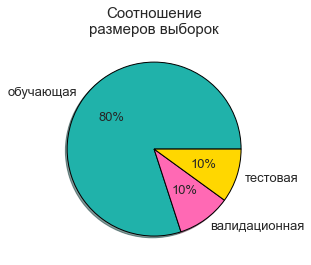

In [39]:
(target_boost,
 target_train_boost,
 target_valid_boost,
 target_test_boost,
 features_boost,
 features_train_boost,
 features_valid_boost,
 features_test_boost) = split_data (df_ml)

Создадим функцию формирования признаков `make_features`.

На входе функции:
- `df` - датафрейм
- `max_lag` 
- `rolling_mean_size`

#### Функция обучения, предсказаний и получения метрик модели

Cоздадим функцию `boost_metrics()`.

На входе функции:
- `model_name` - модель бустинга
- `parameter_change` - наименование изменяемого гиперпараметра
- `parameter_range` - диапазон изменения гиперпараметра
- `parameters_other` - словарь дополнительных параметров, если дополнительные параметры отсутствуют, то необходимо передать пустой словарь {}
- `target_train` - целевой признак обучающей выборки
- `target_valid` - целевой признак валидационной выборки
- `features_train` - признаки обучающей выборки
- `features_valid` - признаки валидационной выборки

На выходе функции:
- `model_best` - лучшая модель
- `metrics` - датафрейм с метриками модели
- `rmse_best` - лучшее значение метрики `RMSE`

Датафрейм `metrics`:
- `model` - модель     
- `rmse` - значение метрики RMSE для выбранной модели      
- `rmse_base` - значение метрики RMSE для базовой (константной) модели   
- `rmse_max` - предельное значение метрики RMSE согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели
- `best_iteration` - лучшая итерация
- `f'{parameter_change}'` - значения изменяемого гиперпараметра

Функция также выполняет визуализацию результатов.

In [40]:
def boost_metrics(model_name:'ModelBoosting',
                  parameter_change:'str_name',
                  parameter_range:'range',
                  parameters_other:'dict',
                  target_train: pd.Series,
                  target_valid: pd.Series,
                  features_train: pd.DataFrame,
                  features_valid: pd.DataFrame):
    
    time_fit_list = []
    time_pred_list = []
    rmse_list = []
    sanity_list = []
    quality_list = []
    iteration_list = []
    legend_list = []
    evals_list = []
    
    '''Baseline'''
    
    predictions_base = target_valid.shift(fill_value=int(target_train.iloc[-1])) # предсказания предыдущим значением ряда
    rmse_base = rmse_score(target_valid, predictions_base)                       # вычисление RMSE
    rmse_best = rmse_base

    '''Обучение, предсказания модели, вычисление времени кода'''
    
    for parameter in parameter_range:
        
        if model_name == CatBoostRegressor:
            
            print(f'\033[1m\033[4mОбучение модели при гиперпараметре {parameter_change}={parameter}\033[0m')
        
            params = {**{'eval_metric'          : 'RMSE',
                         'random_seed'          : 42,
                         'verbose'              : False,
                         'n_estimators'         : 1500,
                         'early_stopping_rounds': 200,
                         parameter_change : parameter},
                      
                      **parameters_other}
        
            model = model_name(**params)
            
            start_fit = time.time()     
            model.fit(features_train,
                      target_train,
                      eval_set=(features_valid, target_valid),
                      plot=True)                                 # обучение модели        
            time_fit = time.time() - start_fit                   # время обучения модели
            
        if model_name == LGBMRegressor:            
           
            params = {**{'boosting_type'        : 'gbdt',
                         'force_col_wise'       : True,
                         'n_estimators'         : 1000,
                         'num_leaves'           : 40,
                         'random_state'         : 42,
                         parameter_change       : parameter},
                        
                      **parameters_other}
        
            model = model_name(**params)
            
            start_fit = time.time()     
            model.fit(features_train,
                      target_train,
                      eval_set=(features_valid, target_valid),
                      verbose=False,
                      early_stopping_rounds=200,
                      eval_metric='rmse')                      # обучение модели        
            time_fit = time.time() - start_fit                 # время обучения модели
            
            evals_list.append(model.evals_result_)
            legend_list.append(f'{parameter_change}={parameter}')
        
        time_fit_list.append(time_fit)
        
        start_pred = time.time()
        predictions = model.predict(features_valid)            # предсказания модели
        time_pred = time.time() - start_pred                   # время предсказания модели
        
        time_pred_list.append(time_pred)
        
        rmse = rmse_score(target_valid, predictions)           # вычисление RMSE
        rmse_list.append(rmse)      
        sanity_list.append(rmse < rmse_base)
        quality_list.append(rmse < rmse_max)
        iteration_list.append(model.best_iteration_)
        
        '''Выбор лучшей модели'''
        
        if rmse < rmse_best:
            model_best = model
            rmse_best = rmse
            best_parameter = parameter
    
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'               : [model_name]*len(parameter_range),
                            'rmse'                : rmse_list,
                            'rmse_base'           : [rmse_base]*len(parameter_range),
                            'rmse_max'            : [rmse_max]*len(parameter_range),
                            'sanity'              : sanity_list,
                            'quality'             : quality_list,
                            'time_fit'            : time_fit_list,
                            'time_pred'           : time_pred_list,
                            'best_iteration'      : iteration_list,
                            f'{parameter_change}' : parameter_range}) 
    
    display(metrics)
    
    if rmse_best < rmse_base:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает базовому уровню, модель невменяема.'+color.END)
    
    if rmse_best < rmse_max:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)
        
    '''Визуализация результатов'''
    
    if model_name == LGBMRegressor:
        
        '''График зависимости метрики RMSE от количества итераций'''
        
        _, ax = plt.subplots(figsize=(15,10))
        
        for e_res in evals_list:
            lgb.plot_metric(e_res,
                            metric = 'rmse',
                            ax=ax)
        
        ax.set_title('Зависимость метрики RMSE от количества итераций')
        ax.legend(legend_list);
    
    '''Тепловая карта'''  

    fig, ax = plt.subplots(1, 4, figsize=(18,4))
    
    fig.subplots_adjust(wspace=1.0)
    
    fig.suptitle('Сравнение результатов обучения на тепловых картах', y = 1.1, fontsize = 18)
    
    for i, yticklabels, title, met in zip(range(4),
                                          [True, False, False, False],
                                          ['Метрика\nRMSE',
                                           'Время\nобучения',
                                           'Время\nпредсказания',
                                           'Лучшая\nитерация'],                                            
                                           ['rmse', 'time_fit', 'time_pred', 'best_iteration']):
        
        metrics_heat = metrics.set_index(f'{parameter_change}')[[met]]
        
        sns.heatmap(metrics_heat,
                    annot=True,
                    annot_kws={"size": 14},
                    fmt= '.3f',
                    ax=ax[i],
                    cmap='RdYlGn_r',
                    linewidths=1.0)
        
        ax[i].set_title(f'{title}', fontsize = 14, y=1.005);    
    
    return model_best, metrics, rmse_best

#### CatBoostRegressor

Проверим, как модель работает с параметрами по умолчанию.

In [41]:
model_cat, metrics_cat = model_metrics(CatBoostRegressor(verbose=False, random_state=42),
                                       target_train_boost,
                                       target_valid_boost,
                                       features_train_boost,
                                       features_valid_boost)

model   rmse  \
0  <catboost.core.CatBoostRegressor object at 0x00000000287AA5E0> 33.185   

   rmse_base  rmse_max  sanity  quality  time_fit  time_pred  
0     47.249        48    True     True     1.486      0.002

Качество лучше базового уровня, модель вменяема.
Качество лучше предельного по исходным данным.


##### Обучение, предсказания и получение метрик модели

Обучение модели при гиперпараметре learning_rate=0.02


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре learning_rate=0.04


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре learning_rate=0.06


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model   rmse  rmse_base  rmse_max  \
0  <class 'catboost.core.CatBoostRegressor'> 33.156     47.249        48   
1  <class 'catboost.core.CatBoostRegressor'> 32.789     47.249        48   
2  <class 'catboost.core.CatBoostRegressor'> 32.827     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration  learning_rate  
0    True     True     3.147      0.002             806          0.020  
1    True     True     2.051      0.002             469          0.040  
2    True     True     1.343      0.002             228          0.060

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 23 s
Wall time: 7.12 s


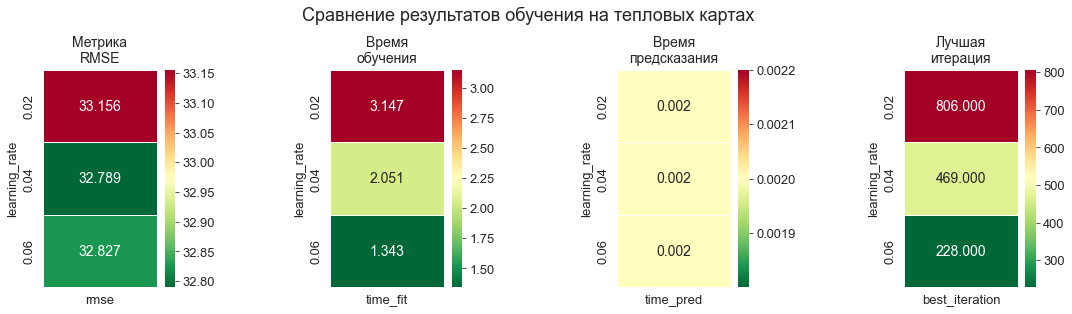

In [42]:
%%time
model_cat, metrics_cat, rmse_cat = boost_metrics(CatBoostRegressor,
                                                 'learning_rate',
                                                 [0.02, 0.04, 0.06],
                                                 {'depth': 8},
                                                 target_train_boost,
                                                 target_valid_boost,
                                                 features_train_boost,
                                                 features_valid_boost)

Обучение модели при гиперпараметре depth=5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре depth=8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре depth=10


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model   rmse  rmse_base  rmse_max  \
0  <class 'catboost.core.CatBoostRegressor'> 32.691     47.249        48   
1  <class 'catboost.core.CatBoostRegressor'> 32.789     47.249        48   
2  <class 'catboost.core.CatBoostRegressor'> 33.157     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration  depth  
0    True     True     0.781      0.003             460      5  
1    True     True     2.443      0.002             469      8  
2    True     True     5.597      0.003             245     10

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 28.8 s
Wall time: 9.36 s


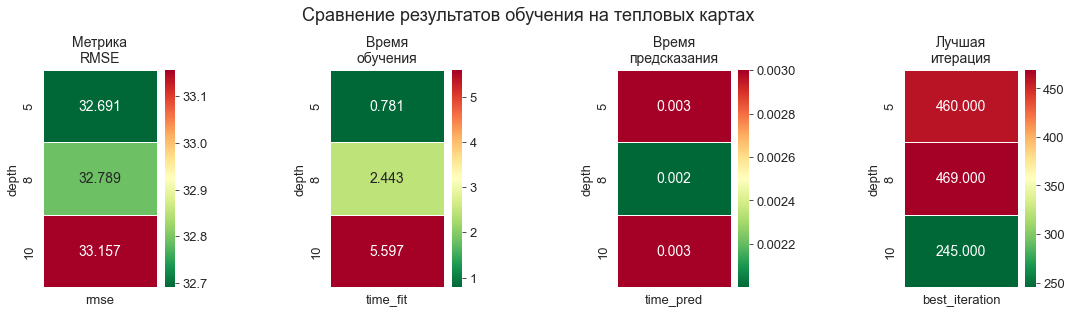

In [43]:
%%time
model_cat, metrics_cat, rmse_cat = boost_metrics(CatBoostRegressor,
                                                 'depth',
                                                 [5, 8, 10],
                                                 {'learning_rate': 0.04},
                                                 target_train_boost,
                                                 target_valid_boost,
                                                 features_train_boost,
                                                 features_valid_boost)

Обучение модели при гиперпараметре loss_function=MAE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре loss_function=MAPE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при гиперпараметре loss_function=RMSE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model   rmse  rmse_base  rmse_max  \
0  <class 'catboost.core.CatBoostRegressor'> 34.192     47.249        48   
1  <class 'catboost.core.CatBoostRegressor'> 54.212     47.249        48   
2  <class 'catboost.core.CatBoostRegressor'> 32.691     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration loss_function  
0    True     True     0.780      0.003             373           MAE  
1   False    False     2.031      0.002            1328          MAPE  
2    True     True     0.802      0.001             460          RMSE

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 11.3 s
Wall time: 4.15 s


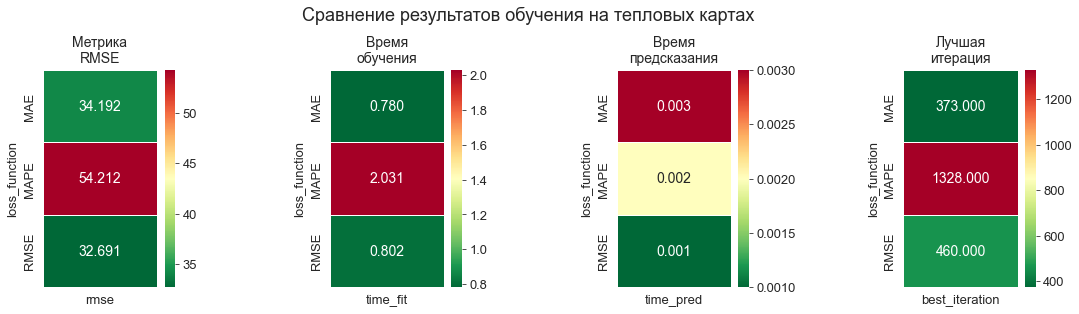

In [44]:
%%time
model_cat, metrics_cat, rmse_cat = boost_metrics(CatBoostRegressor,
                                                 'loss_function',
                                                 ['MAE', 'MAPE', 'RMSE'],
                                                 {'learning_rate': 0.04,
                                                  'depth': 5},
                                                 target_train_boost,
                                                 target_valid_boost,
                                                 features_train_boost,
                                                 features_valid_boost)

##### Лучшая модель

Гиперпараметры лучшей модели

In [45]:
model_cat.get_params()

{'learning_rate': 0.04,
 'depth': 5,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': False,
 'eval_metric': 'RMSE',
 'n_estimators': 1500,
 'early_stopping_rounds': 200}

Качество лучшей модели

In [46]:
print(f'RMSE лучшей модели: {rmse_cat:.2f}')

RMSE лучшей модели: 32.69


#### LGBMRegressor

Проверим, как модель работает с параметрами по умолчанию.

In [47]:
model_light, metrics_light = model_metrics(LGBMRegressor(random_state=42),
                                           target_train_boost,
                                           target_valid_boost,
                                           features_train_boost,
                                           features_valid_boost)

model   rmse  rmse_base  rmse_max  sanity  \
0  LGBMRegressor(random_state=42) 33.023     47.249        48    True   

   quality  time_fit  time_pred  
0     True     0.187      0.001

Качество лучше базового уровня, модель вменяема.
Качество лучше предельного по исходным данным.


##### Обучение, предсказания и получение метрик модели

model   rmse  rmse_base  rmse_max  \
0  <class 'lightgbm.sklearn.LGBMRegressor'> 32.424     47.249        48   
1  <class 'lightgbm.sklearn.LGBMRegressor'> 32.283     47.249        48   
2  <class 'lightgbm.sklearn.LGBMRegressor'> 32.411     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration  learning_rate  
0    True     True     0.258      0.004             282          0.020  
1    True     True     0.265      0.003             178          0.040  
2    True     True     0.341      0.002             128          0.060

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


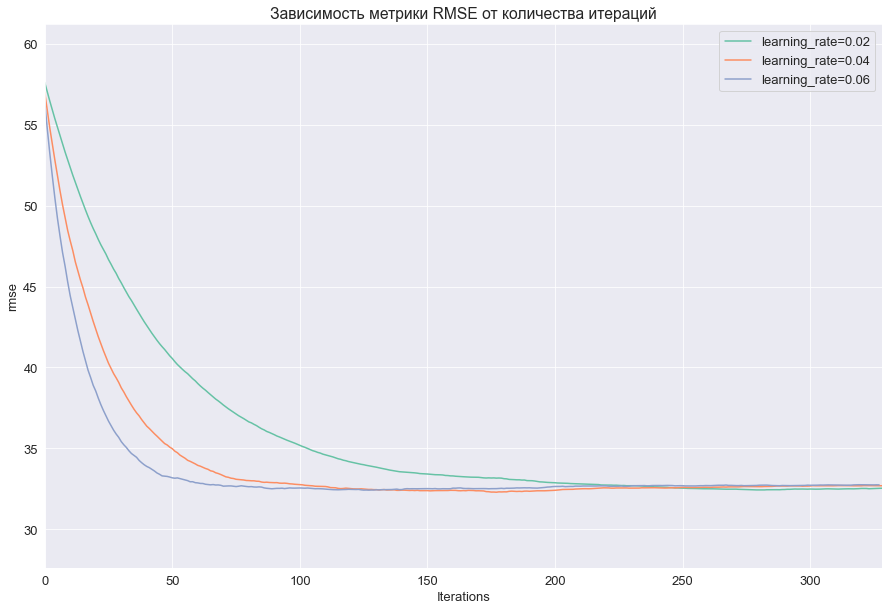

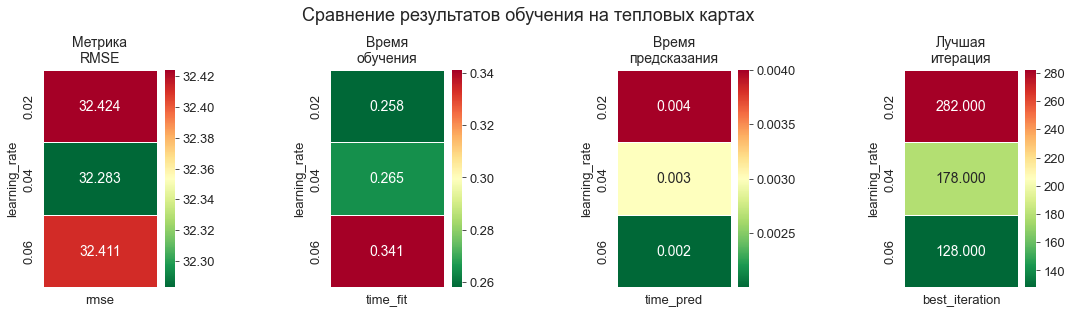

In [48]:
model_light, metrics_light, rmse_light = boost_metrics(LGBMRegressor,
                                                       'learning_rate',
                                                       [0.02, 0.04, 0.06],
                                                       {'max_depth':50},
                                                       target_train_boost,
                                                       target_valid_boost,
                                                       features_train_boost,
                                                       features_valid_boost)

model   rmse  rmse_base  rmse_max  \
0  <class 'lightgbm.sklearn.LGBMRegressor'> 32.723     47.249        48   
1  <class 'lightgbm.sklearn.LGBMRegressor'> 32.585     47.249        48   
2  <class 'lightgbm.sklearn.LGBMRegressor'> 32.283     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration  max_depth  
0    True     True     0.159      0.003             253          5  
1    True     True     0.147      0.003             145         10  
2    True     True     0.231      0.003             178         50

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


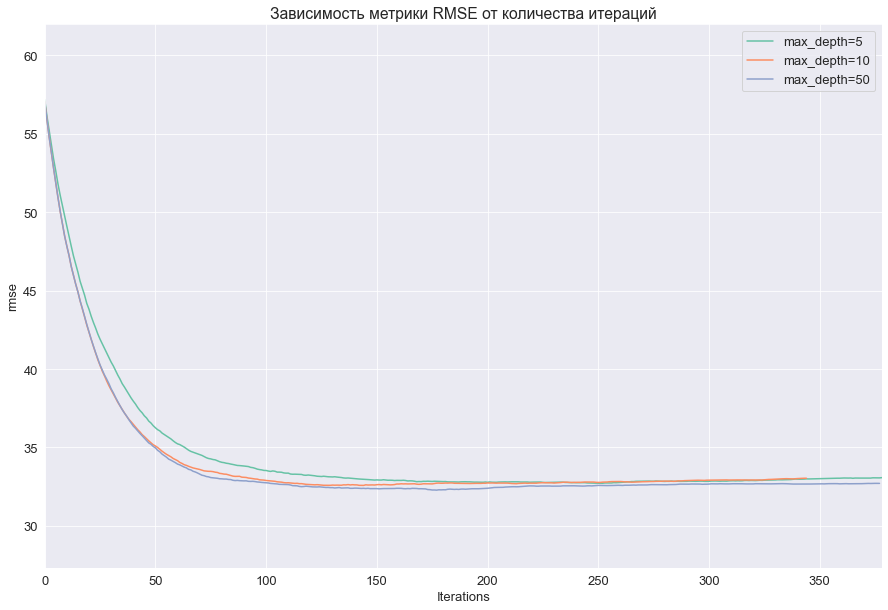

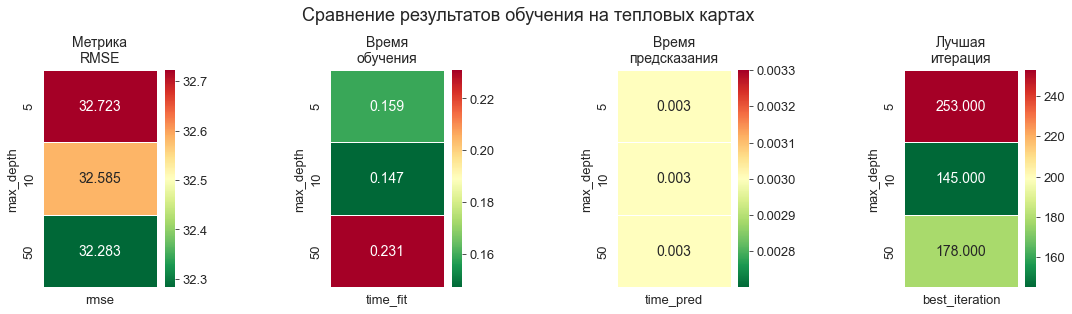

In [49]:
model_light, metrics_light, rmse_light = boost_metrics(LGBMRegressor,
                                                       'max_depth',
                                                       [5, 10, 50],
                                                       {'learning_rate':0.04},
                                                       target_train_boost,
                                                       target_valid_boost,
                                                       features_train_boost,
                                                       features_valid_boost)

model   rmse  rmse_base  rmse_max  \
0  <class 'lightgbm.sklearn.LGBMRegressor'> 32.283     47.249        48   
1  <class 'lightgbm.sklearn.LGBMRegressor'> 32.403     47.249        48   
2  <class 'lightgbm.sklearn.LGBMRegressor'> 32.741     47.249        48   

   sanity  quality  time_fit  time_pred  best_iteration  min_split_gain  
0    True     True     0.207      0.003             178               0  
1    True     True     0.191      0.003             188              25  
2    True     True     0.122      0.002             135             100

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


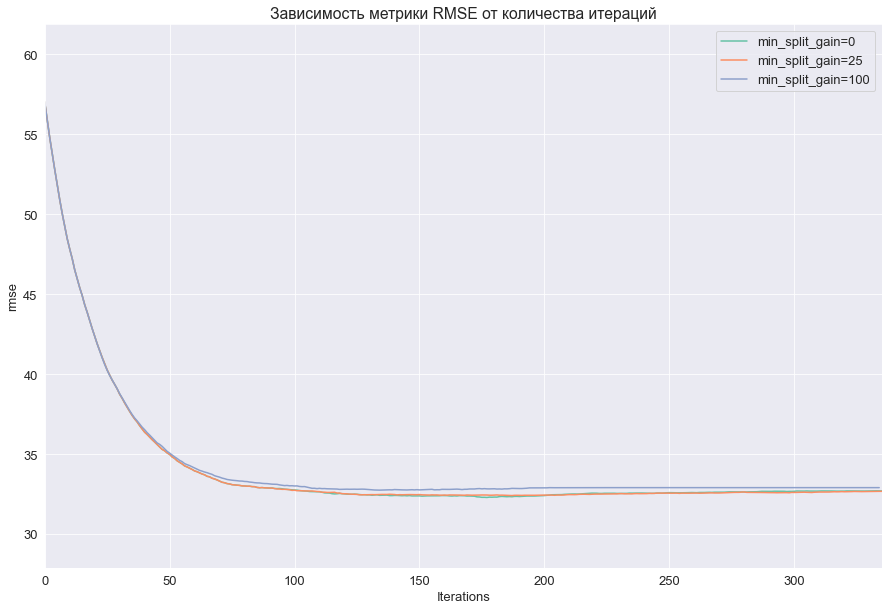

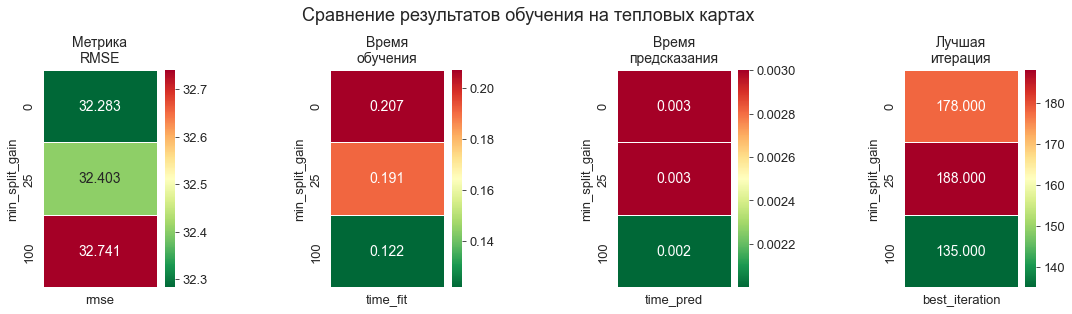

In [50]:
model_light, metrics_light, rmse_light = boost_metrics(LGBMRegressor,
                                                       'min_split_gain',
                                                       [0, 25, 100],
                                                       {'learning_rate':0.04,
                                                        'max_depth':50},
                                                       target_train_boost,
                                                       target_valid_boost,
                                                       features_train_boost,
                                                       features_valid_boost)

#### Лучшая модель

Гиперпараметры лучшей модели

In [51]:
model_light.set_params()

LGBMRegressor(force_col_wise=True, learning_rate=0.04, max_depth=50,
              min_split_gain=0, n_estimators=1000, num_leaves=40,
              random_state=42)

Качество лучшей модели

In [52]:
print(f'RMSE лучшей модели: {rmse_light:.2f}')

RMSE лучшей модели: 32.28


### Выбор лучшей модели 

#### Сравнение результатов

Объединим результаты лучших моделей в единый датасет.

In [53]:
metrics_line['model']  = 'LinearRegression'
metrics_ridge['model'] = 'Ridge'
metrics_cat['model']   = 'CatBoostRegressor'
metrics_light['model'] = 'LGBMRegressor'

metrics_all = pd.concat([metrics_light.loc[metrics_light['rmse'] == metrics_light['rmse'].min()],
                         metrics_cat.loc[metrics_cat['rmse'] == metrics_cat['rmse'].min()],
                         metrics_line,
                         metrics_ridge]).set_index('model')

metrics_all = metrics_all[['rmse', 'time_fit', 'time_pred']].sort_values(by='rmse')

In [54]:
metrics_all

rmse  time_fit  time_pred
model                                        
LGBMRegressor     32.283     0.207      0.003
LinearRegression  32.563     0.003      0.001
Ridge             32.565     0.002      0.002
CatBoostRegressor 32.691     0.802      0.001

Сравним метрики графически.

In [55]:
def compare_metrics(metrics: pd.DataFrame):    
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    
    fig.subplots_adjust(wspace=1.0)
    
    fig.suptitle('Сравнение метрик моделей на тепловых картах', y = 1.1, fontsize = 18)
    
    for i, yticklabels, title, met in zip(range(3),
                                          [True, False, False],
                                          ['Метрика\nRMSE',
                                           'Время\nобучения',
                                           'Время\nпредсказания'],                                            
                                           ['rmse', 'time_fit', 'time_pred']):
        
        metrics_heat = metrics[[met]]
        
        sns.heatmap(metrics_heat,
                    annot=True,
                    annot_kws={"size": 14},
                    fmt= '.3f',
                    ax=ax[i],
                    cmap='RdYlGn_r',
                    linewidths=1.0)
        
        ax[i].set_title(f'{title}', fontsize = 14, y=1.005);   

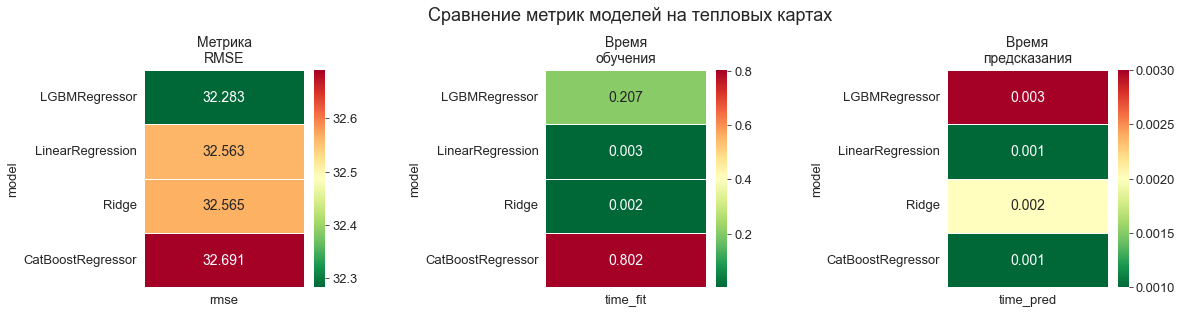

In [56]:
compare_metrics(metrics_all)

- Качество линейных моделей уступает качеству моделей бустинга.
- Лучшая по качеству и времени обучения модель - `LGBMRegressor`.
- Для заказчика наиболее оптимальной является модель `LGBMRegressor`.

### Проверка качества лучшей модели на тестовой выборке

#### Проверка качества модели, обученной на 80% данных

model   rmse  rmse_base  rmse_max  \
0  <class 'lightgbm.sklearn.LGBMRegressor'> 54.424     58.978        48   
1  <class 'lightgbm.sklearn.LGBMRegressor'> 54.314     58.978        48   
2  <class 'lightgbm.sklearn.LGBMRegressor'> 54.281     58.978        48   

   sanity  quality  time_fit  time_pred  best_iteration  learning_rate  
0    True    False     0.415      0.007             544          0.010  
1    True    False     0.267      0.003             280          0.020  
2    True    False     0.216      0.003             144          0.040

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.


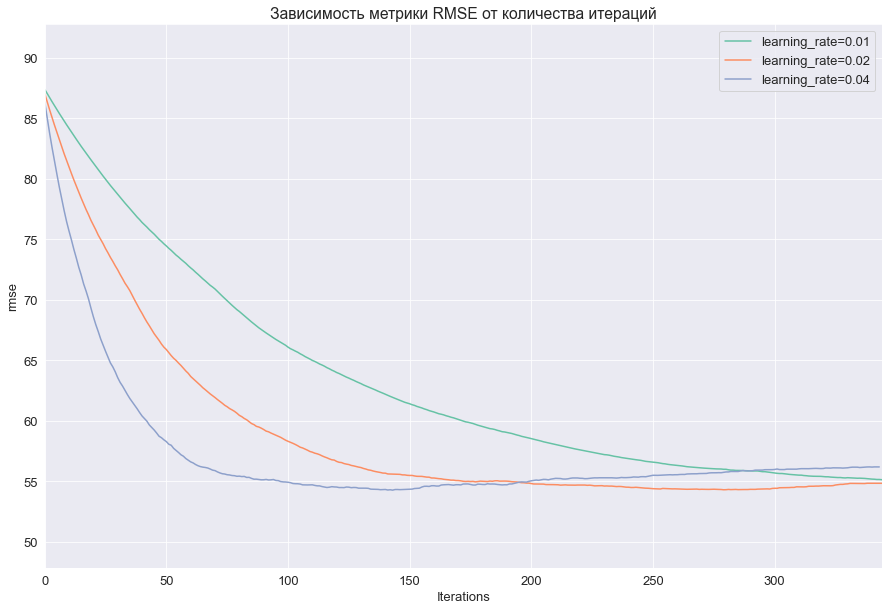

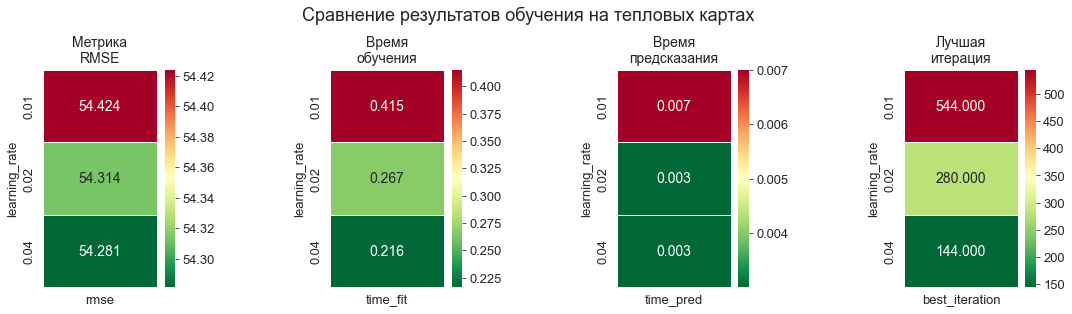

In [57]:
model_light_80, metrics_light_80, rmse_light_80 = boost_metrics(LGBMRegressor,
                                                                'learning_rate',
                                                                [0.01, 0.02, 0.04],
                                                                {'max_depth':50},
                                                                target_train_boost,
                                                                target_test_boost,
                                                                features_train_boost,
                                                                features_test_boost)

Качество выбранной модели уступает предельному по исходным данным, поэтому попробуем обучить модель с подобранными гиперпараметрами на временном ряду вплоть до начала тестовой выборки.

#### Проверка качества модели, обученной на 90% данных

Объединим обучающую и валидационную выборки.

In [58]:
target_full_boost = pd.concat([target_train_boost, target_valid_boost])
features_full_boost = pd.concat([features_train_boost, features_valid_boost])

In [59]:
if target_full_boost.index.is_monotonic and features_full_boost.index.is_monotonic:
    print (color.BOLD+color.OKGREEN+'Выборки упорядочены по индексу')
else:
    print (color.BOLD+color.FAIL+'Выборки не упорядочен по индексу')

Выборки упорядочены по индексу


model   rmse  rmse_base  rmse_max  \
0  <class 'lightgbm.sklearn.LGBMRegressor'> 41.868     58.918        48   
1  <class 'lightgbm.sklearn.LGBMRegressor'> 41.582     58.918        48   
2  <class 'lightgbm.sklearn.LGBMRegressor'> 42.172     58.918        48   

   sanity  quality  time_fit  time_pred  best_iteration  learning_rate  
0    True     True     0.531      0.007             730          0.010  
1    True     True     0.550      0.007             590          0.020  
2    True     True     0.200      0.003             212          0.040

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


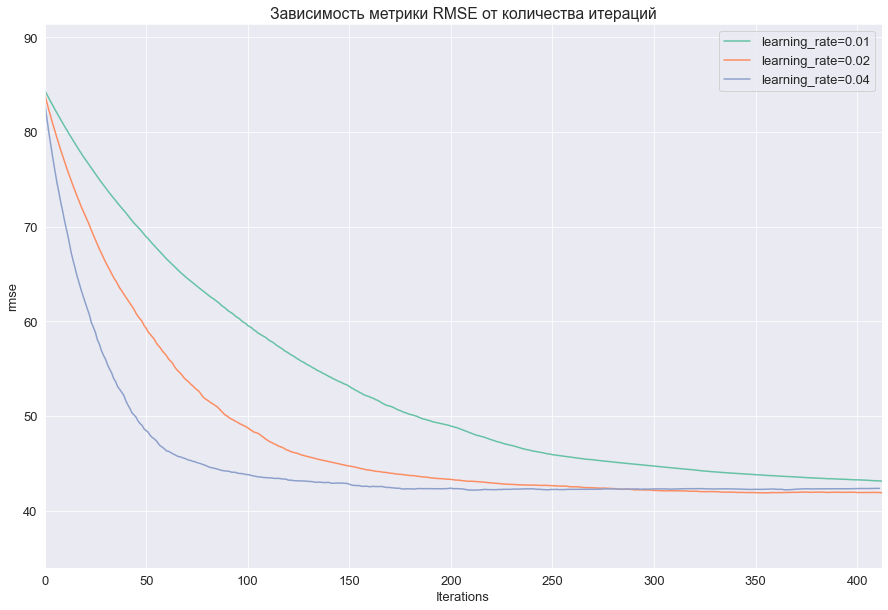

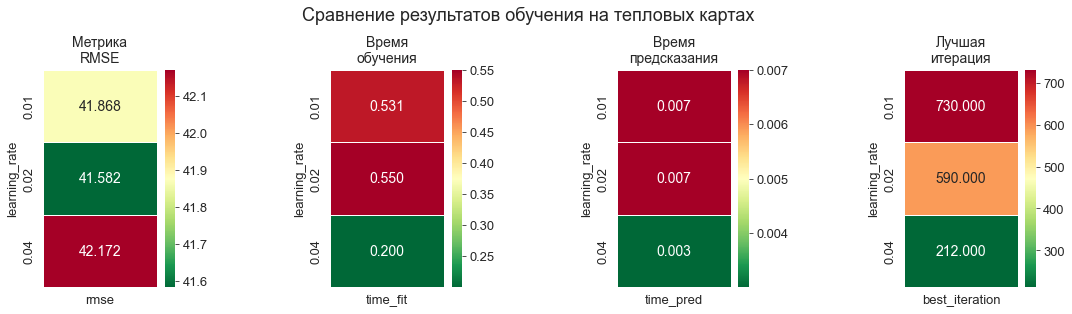

In [60]:
model_light_90, metrics_light_90, rmse_light_90 = boost_metrics(LGBMRegressor,
                                                                'learning_rate',
                                                                [0.01, 0.02, 0.04],
                                                                {'max_depth':50},
                                                                target_full_boost,
                                                                target_test_boost,
                                                                features_full_boost,
                                                                features_test_boost)

Объединим результаты лучших моделей в единый датасет.

In [61]:
metrics_light_80['model'] = 'LGBMRegressor_80'
metrics_light_90['model'] = 'LGBMRegressor_90'

metrics_test = pd.concat([metrics_light_80.loc[metrics_light_80['rmse'] == metrics_light_80['rmse'].min()],
                         metrics_light_90.loc[metrics_light_90['rmse'] == metrics_light_90['rmse'].min()]
                        ]).set_index('model')

metrics_test = metrics_test[['rmse', 'time_fit', 'time_pred']].sort_values(by='rmse')

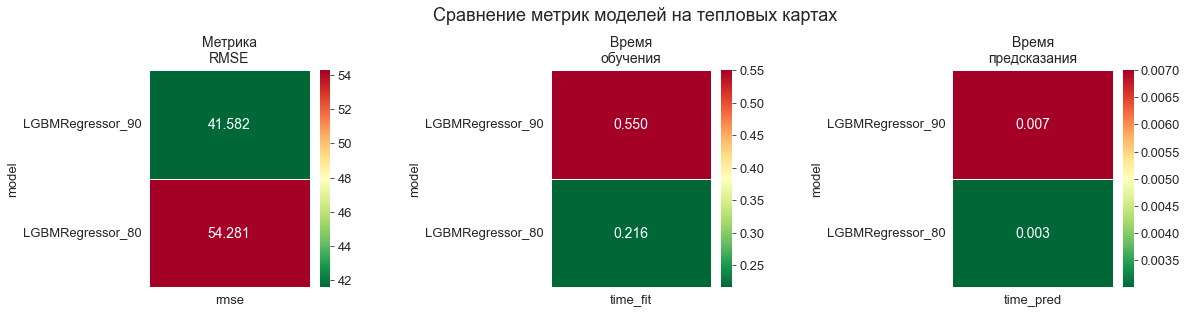

In [62]:
compare_metrics(metrics_test)

Лучшая модель - обученная на 90% данных при подобранных на валидации и немного скорректированных на тесте гиперпараметрах.

Сохраним предсказания лучшей модели в отдельную переменную.

In [63]:
pred_test_light = model_light_90.predict(features_test_boost)

Качество лучшей модели.

In [64]:
print(f'RMSE лучшей модели на тестовой выборке: {rmse_light_90:.2f}')

RMSE лучшей модели на тестовой выборке: 41.58


Модель прошла проверку на тестовой выборке, качество удовлетворяет требованиям заказчика.

## Интерпретация результатов машинного обучения

### Сравнение распределений данных между таргетом и предсказаниями

Объединим таргет, предсказания в общий датасет `target_pred`

In [65]:
target_pred = pd.concat([target_test_boost,
                         pd.DataFrame(pred_test_light, index=target_test_boost.index).rename(columns={0:'num_orders_pred'})],
                         axis=1)

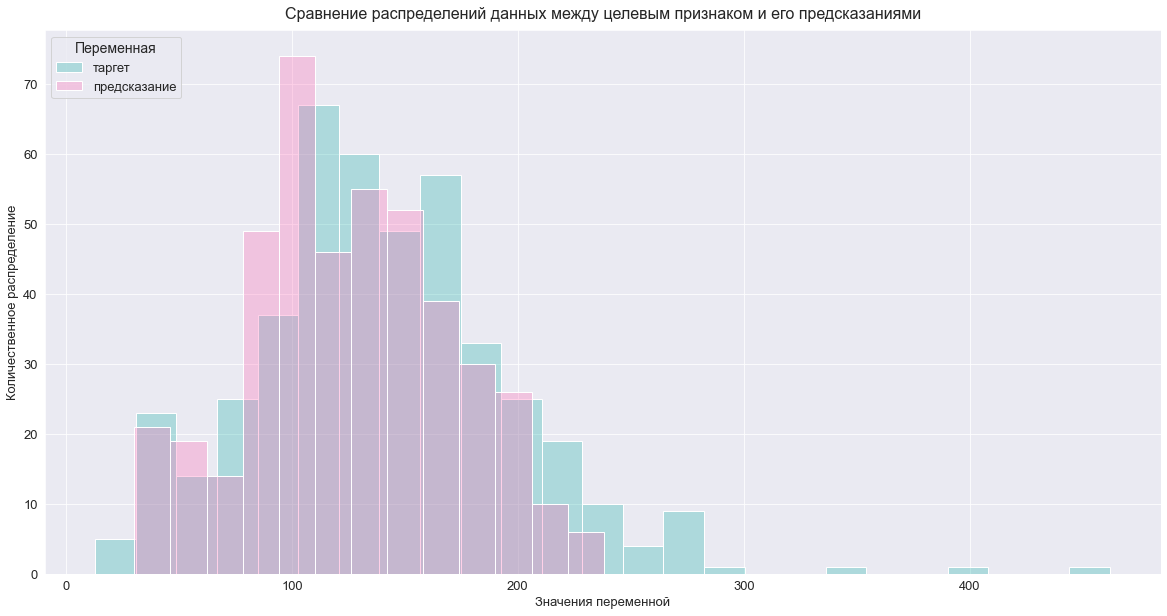

In [66]:
plt.figure(figsize=(20,10))
    
for num, c in zip(['num_orders', 'num_orders_pred'],
                  ['lightseagreen', 'hotpink']):
    
    sns.histplot(data=target_pred,
                 x=num,
                 color=c,
                 alpha=.3)        
    
plt.title('Сравнение распределений данных между целевым признаком и его предсказаниями',
          fontsize=16, y=1.01)

plt.legend(['таргет', 'предсказание'],
           title='Переменная',
           title_fontsize = 14,
           loc='upper left')
plt.xlabel('Значения переменной')
plt.ylabel('Количественное распределение')
plt.show()

- Смещение данных относительно нормального распределения отрицательно влияет на качество модели.
- Большинство значений предсказаний находятся в диапазоне нормального распределения таргета, выбивающиеся значения предсказываются хуже.

### Визуализация разницы между целевым признаком и предсказаниями

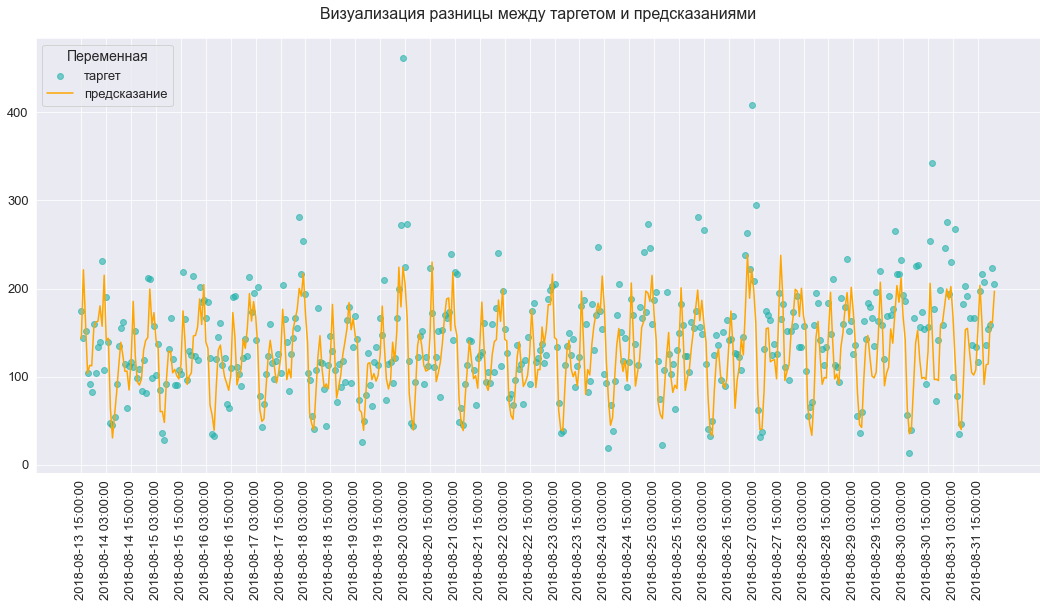

In [67]:
target_pred_date = pd.date_range(start=target_pred.index.min(), end=target_pred.index.max(), freq='12H')

plt.figure(figsize=(18, 8))
plt.scatter(target_pred.index, target_pred['num_orders'], c='lightseagreen', alpha=0.6)
plt.plot(target_pred.index, target_pred['num_orders_pred'], c='orange')
plt.title('Визуализация разницы между таргетом и предсказаниями', fontsize=16, y=1.03)


plt.legend(['таргет', 'предсказание'],
           title='Переменная',
           title_fontsize = 14,
           loc='upper left')

plt.xticks(ticks = target_pred_date,
           labels = target_pred_date,
           rotation=90);

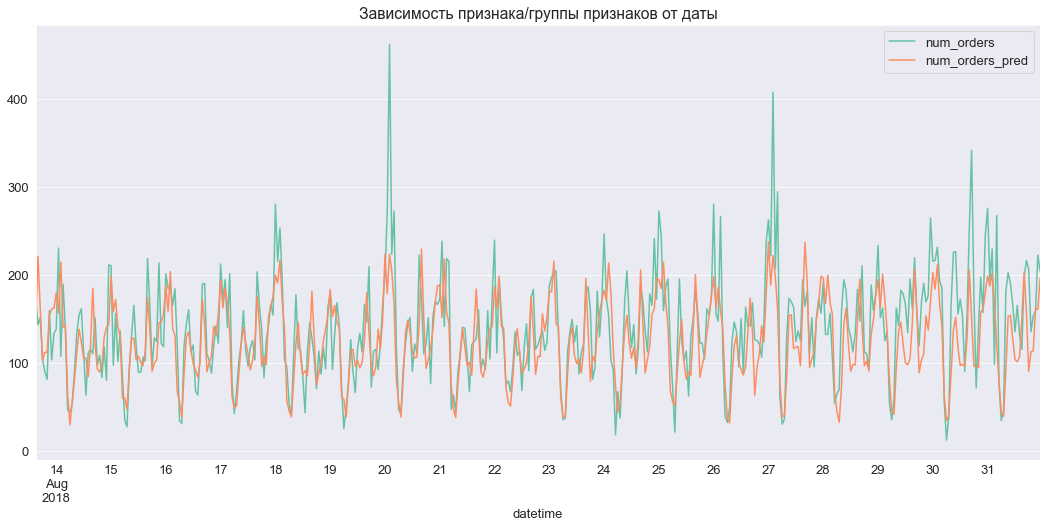

In [68]:
plot_time (target_pred, ['num_orders', 'num_orders_pred'])

- По графикам видно что редкие и выбивающиеся значения предсказываются хуже.
- В пятницу и выходные дни предсказания менее точные.
- В конце месяца предсказания менее точные.

### Влияние признаков на предсказания

#### Пояснение предсказаний модели с помощью SHAP

In [69]:
%%time
explainer = shap.TreeExplainer(model_light_90)
shap_values = explainer.shap_values(features_test_boost)

CPU times: total: 4.48 s
Wall time: 1.95 s


#### Подготовка данных

Сохраним список столбцов признаков в отдельную переменную

In [70]:
X = features_test_boost.columns

Сохраним список столбцов вкладов признаков в предсказание в отдельную переменную

In [71]:
shap_cols = [x+'_shap' for x in X]

Создадим датасет `shap_values_df` из значений вкладов признаков в предсказание

In [72]:
shap_values_df = pd.DataFrame(shap_values, columns = shap_cols, index=target_test_boost.index)

Объединим датасеты `target_pred`, `features_test_boost` и `shap_values_df` в общий датасет `test_shap`

In [73]:
test_shap = pd.concat([target_pred, features_test_boost, shap_values_df],axis=1)

In [74]:
test_shap.head()

num_orders  num_orders_pred  dayofweek  day  month  \
datetime                                                                  
2018-08-13 15:00:00         175          143.376          0   13      8   
2018-08-13 16:00:00         144          221.278          0   13      8   
2018-08-13 17:00:00         152          163.078          0   13      8   
2018-08-13 18:00:00         104          103.501          0   13      8   
2018-08-13 19:00:00          91          112.740          0   13      8   

                     seasonal   lag_4   lag_5   lag_6  rolling_mean  \
datetime                                                              
2018-08-13 15:00:00     3.732 144.000 156.000 137.000       102.000   
2018-08-13 16:00:00    29.604  92.000 144.000 156.000       175.000   
2018-08-13 17:00:00     7.920 119.000  92.000 144.000       144.000   
2018-08-13 18:00:00   -15.528 102.000 119.000  92.000       152.000   
2018-08-13 19:00:00    -7.124 175.000 102.000 119.000       104.000   

                     dayofweek_shap  day_shap  month_shap  seasonal_shap  \
datetime                                                                   
2018-08-13 15:00:00          11.244     6.956      35.432          3.919   
2018-08-13 16:00:00           8.005    10.336      54.349         49.327   
2018-08-13 17:00:00          12.903     5.396      43.846         10.114   
2018-08-13 18:00:00           7.148     5.043      29.832        -28.596   
2018-08-13 19:00:00           5.434     5.391      28.321        -13.903   

                     lag_4_shap  lag_5_shap  lag_6_shap  rolling_mean_shap  
datetime                                                                    
2018-08-13 15:00:00       6.851       0.553      -3.933              4.038  
2018-08-13 16:00:00       0.037      11.298      -4.141             13.751  
2018-08-13 17:00:00       1.356       0.892      -2.017             12.272  
2018-08-13 18:00:00       1.169       0.691       0.243              9.654  
2018-08-13 19:00:00       3.486       1.009      -1.381              6.067

Добавим в созданный датасет столбец со значениями ошибок в предсказаниях

In [75]:
test_shap['error'] = test_shap['num_orders_pred'] - test_shap['num_orders']

Посмотрим на распределение ошибок графически

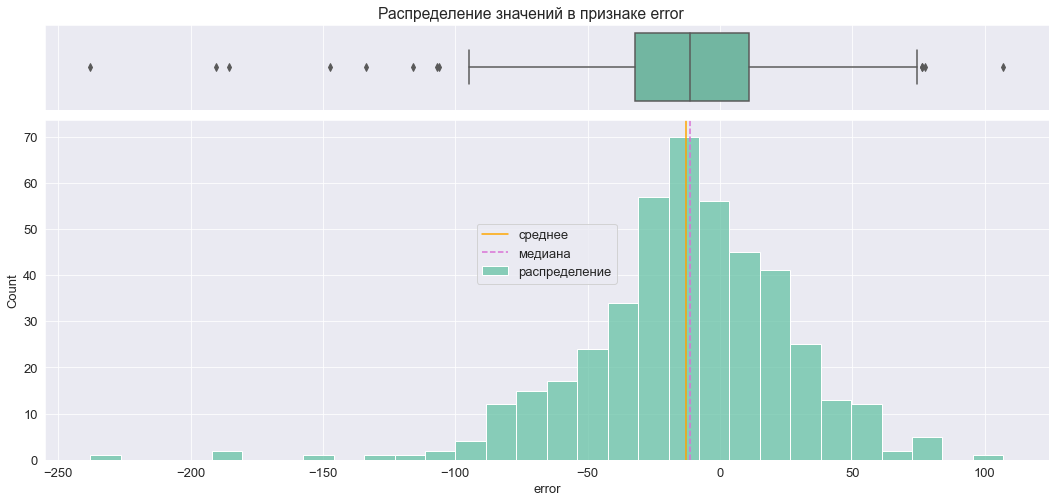

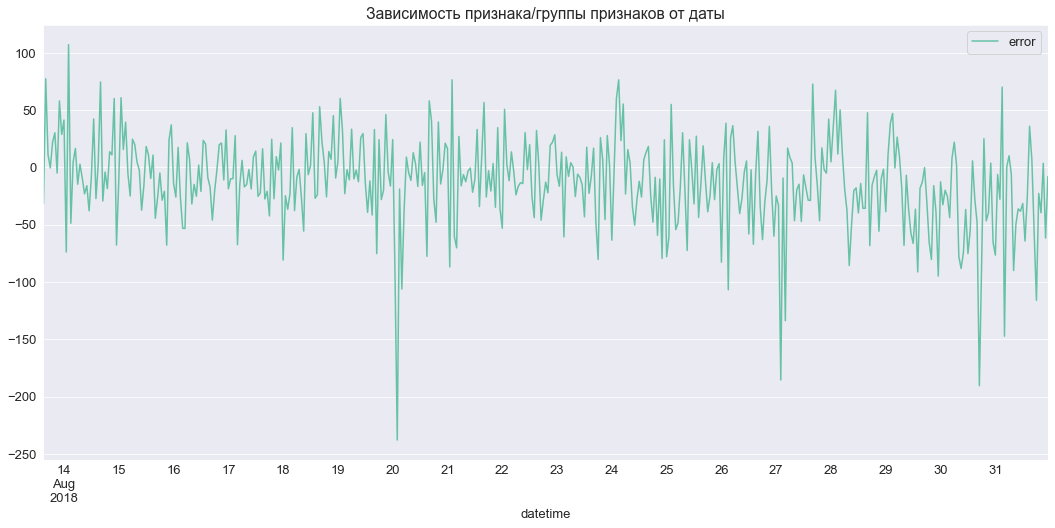

In [76]:
hist_box_plot (test_shap, 'error', bins=30)

- В основном модель отклоняется от целевого признака в диапазоне от -100 до 100.
- Максимальные по модулю ошибки по пятницам (проверено по календарю на 2018 год).

Добавим в созданный датасет столбец со значениями абсолютных ошибок в предсказаниях.

In [77]:
test_shap['error_abs'] = abs(test_shap['error'])

Посмотрим на распределение абсолютных ошибок графически

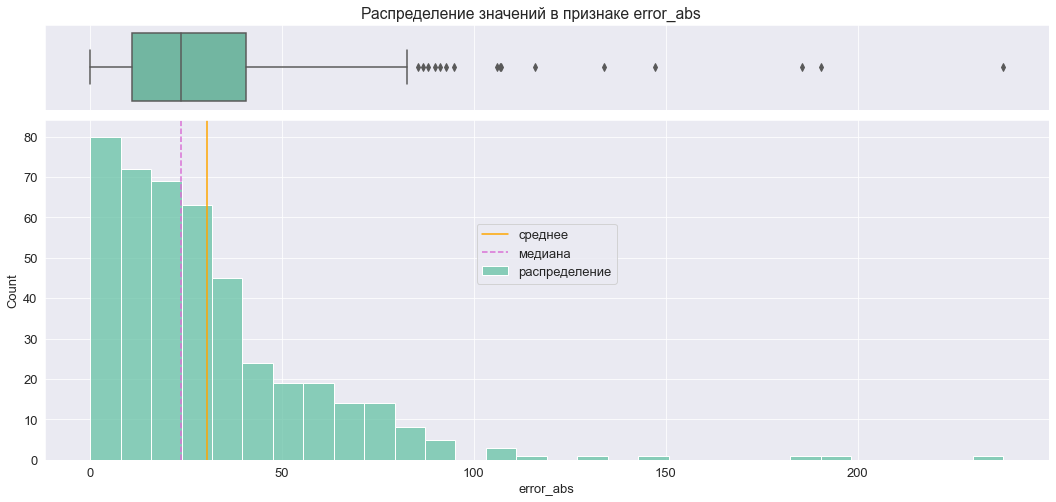

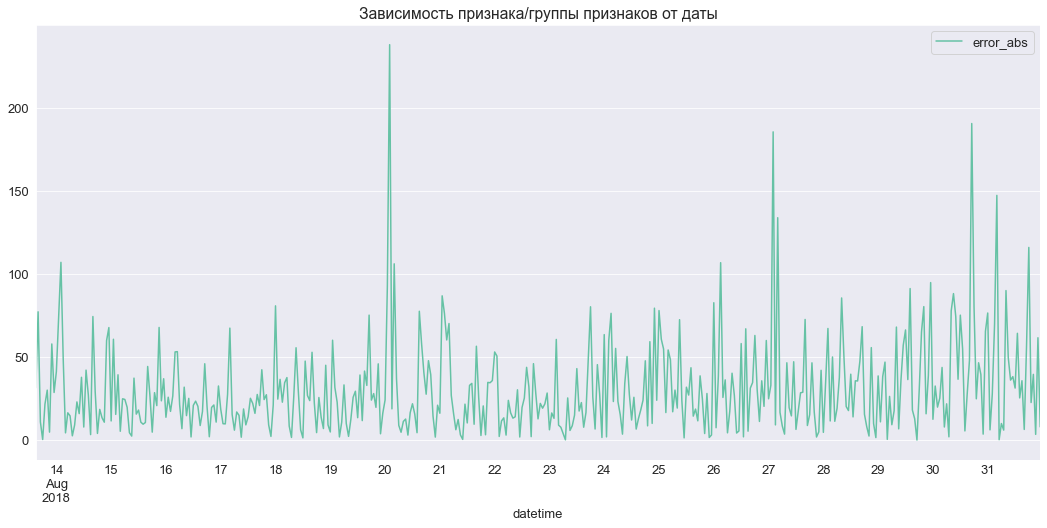

In [78]:
hist_box_plot (test_shap, 'error_abs', bins=30)

- Наблюдения, сделанные ранее стали ещё более наглядными.

Отсортируем данные по значениям абсолютной ошибки в порядке убывания и сохраним результат в отдельную переменную.

In [79]:
test_shap_top = test_shap.sort_values('error_abs', ascending=False)

#### Cводный график важности фичей

Построим сводный график важности признаков.
<br>Пояснения к графику:
- по оси x значения вклада в предсказания (значения Шепли),
- признаки расположены на оси y по мере уменьшения их важности,
- каждая точка – отдельное наблюдение,
- чем толще линия на графике, тем больше таких точек наблюдения,
- цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

Дополнительно к основному сводному графику добавим столбчатую диаграмму средних значений вкладов признаков в предсказания.

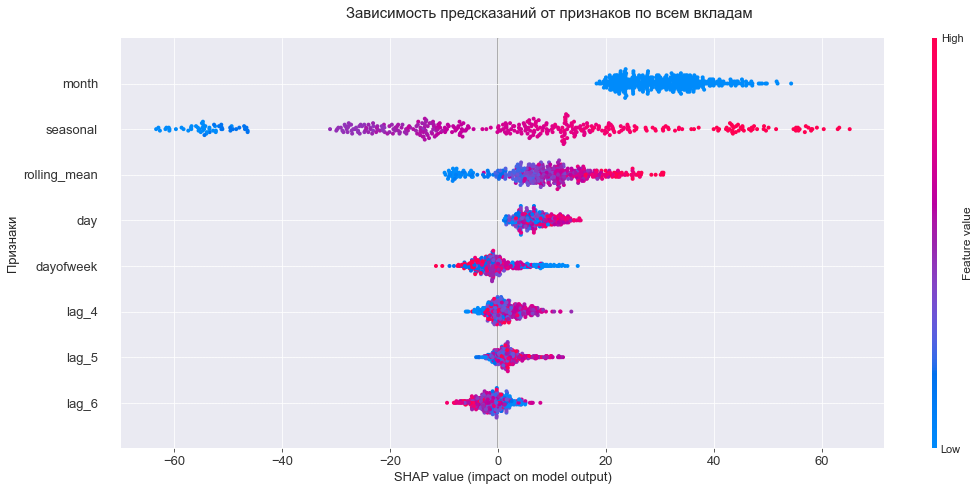

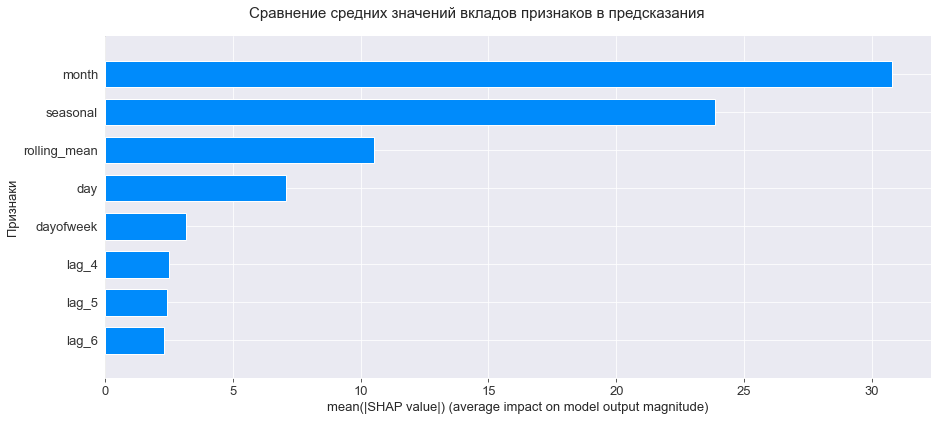

In [80]:
fig, _ = plt.subplots()

fig.suptitle('Зависимость предсказаний от признаков по всем вкладам', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test_boost, plot_size=(15,7), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

fig, _ = plt.subplots()

fig.suptitle('Сравнение средних значений вкладов признаков в предсказания', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test_boost, plot_type="bar", plot_size=(13,6), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

- Месяц вносит максимальный вклад в предсказания.
- Сезонность на втором месте по вкладу в предсказания, с при увеличении значения сезонности предсказания завышаются.
- Скользящее среднее на третьем месте по вкладу в предсказания, с увеличением значения скользящего среднего предсказания завышаются.
- Остальные признаки вносят меньший вклад в предсказания, как увеличивая, так и уменьшая его.

#### Пояснения к графикам аддитивной силы

Визуализируем заданные значения `SHAP` с помощью графика аддитивной силы.<br>График показывает, как разные признаки влияют на итоговое предсказание модели.
- `base value` (базовое значение) – среднее значение, полученное при обучении;
- жирным выделено полученное значение `base value`;
- если значение вклада положительное (красный цвет), то оно увеличивает предсказание, если отрицательное (синий цвет) - уменьшает;
- графики выполняются как интерактивными, так и в формате библиотеки `matplotlib`, в зависимости от задачи визуализации.

#### Графики аддитивной силы для признаков с максимальными ошибками

Проанализируем объекты с 10 самыми большими абсолютными ошибками.

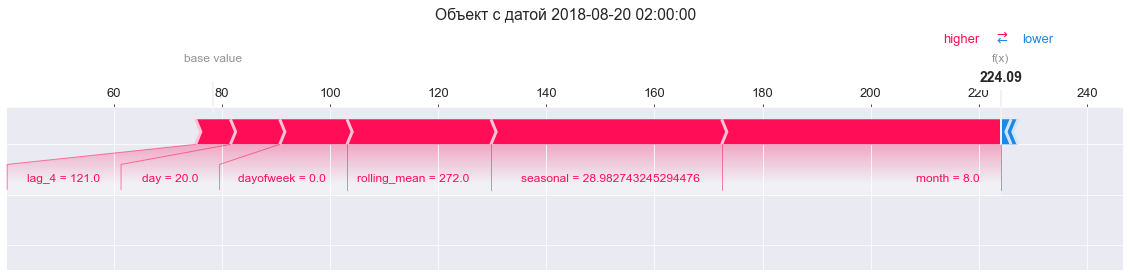

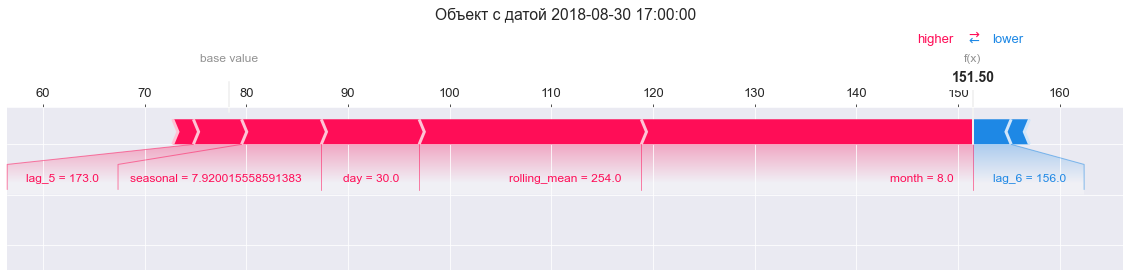

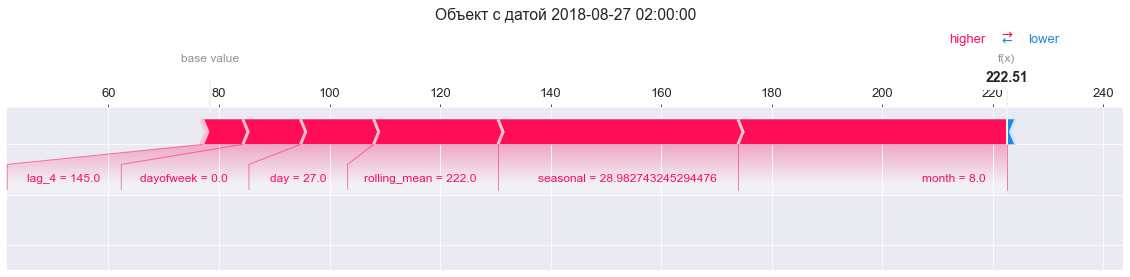

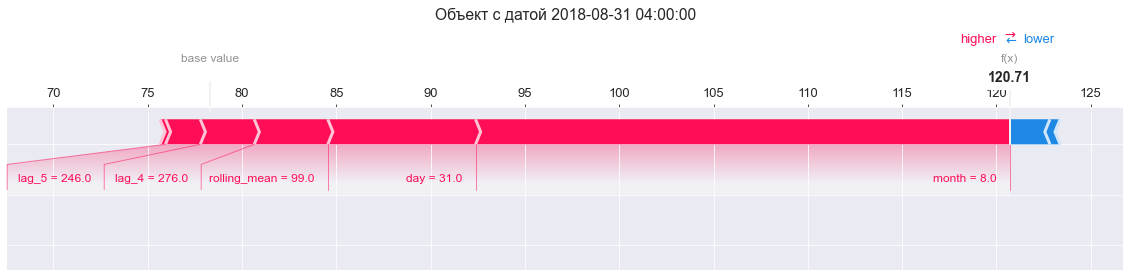

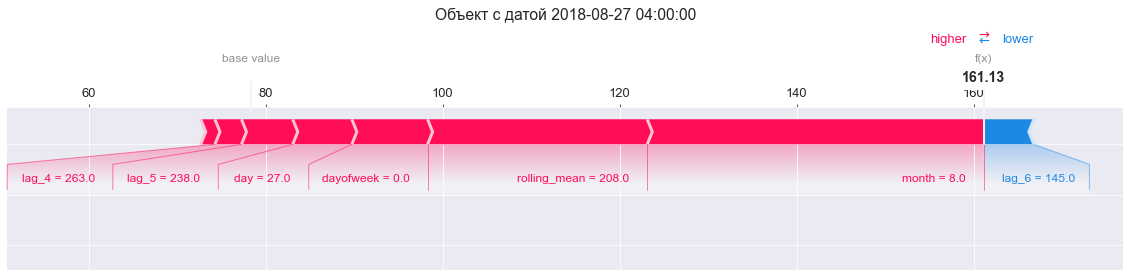

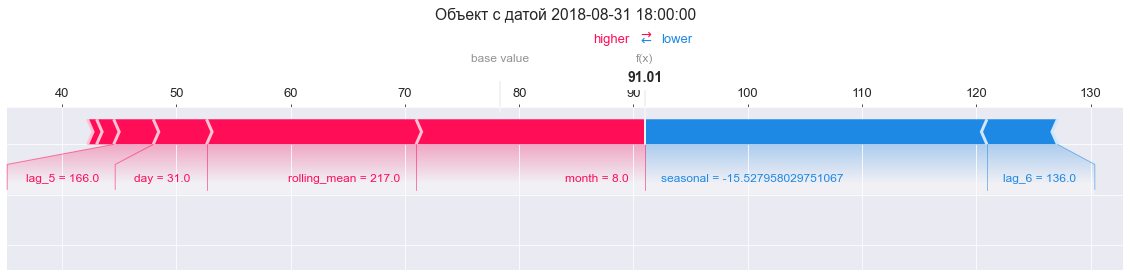

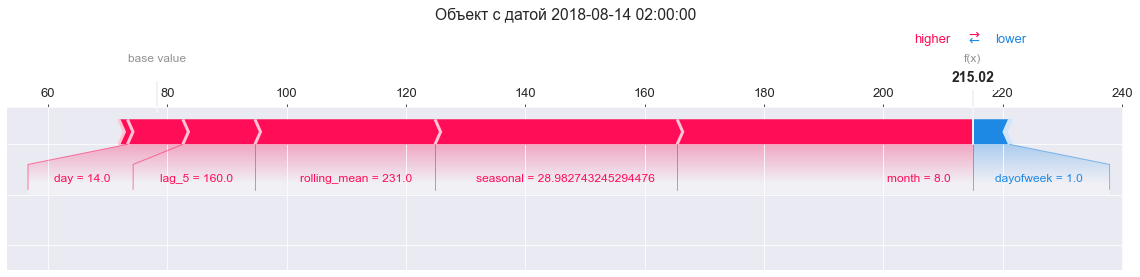

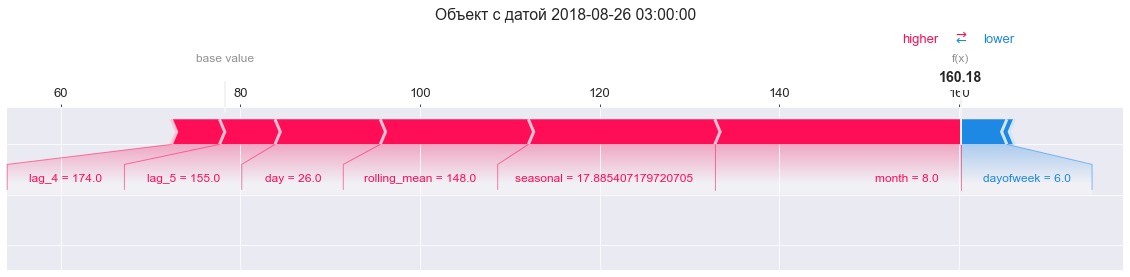

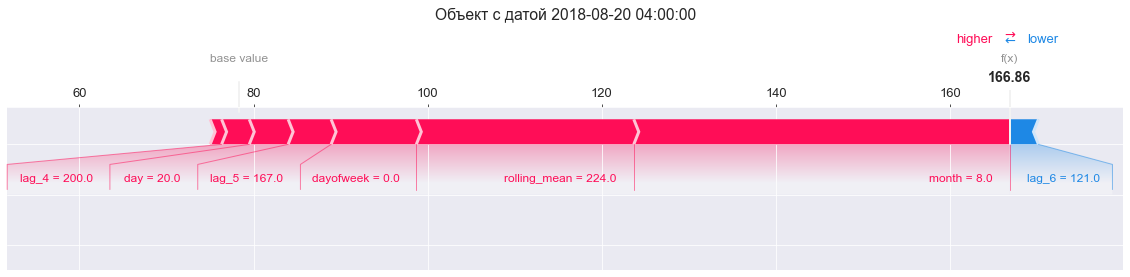

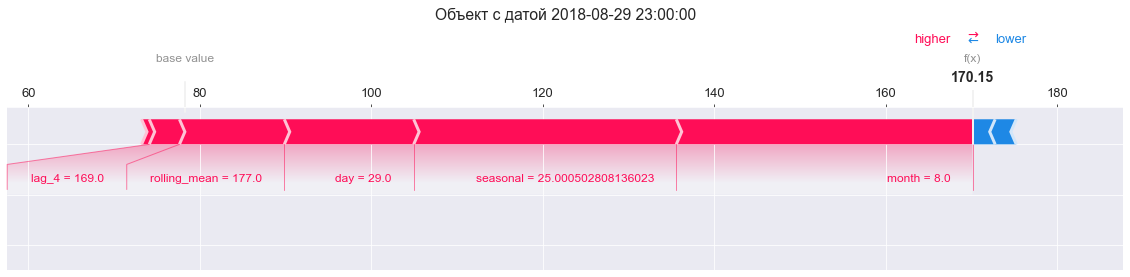

In [81]:
for i in range(10):  
   
    shap.force_plot(explainer.expected_value,
                    test_shap_top[shap_cols].values[i,:],
                    test_shap_top[X].iloc[i,:],
                    matplotlib=True, show=0)
    
    plt.title(f'Объект с датой {test_shap_top.index[i]}', y=1.5)

Выполним график аддитивной силы сразу для всех 10 объектов.

Мы буквально переворачиваем график, полученный выше, на 90 градусов, и повторяем операцию для каждого наблюдения, а затем соединяем всё в один. Это позволяет увидеть интерпретации сразу для каждого наблюдения.

- Графики выполним в интерактивном формате `javascript`, добавив функцию `shap.initjs()`.
- Для анализа поочередно выбираются и сравниваются признаки в левой центральной части графиков и применяется тип сортировки объектов в признаках в верхней центральной части графиков.

In [82]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].head(10).values,
                                          test_shap[X].head(10))

<ins>Месяц:
- признак завышает вклад
    
<ins>Сезонность:
- признак чаще завышает вклад
- модуль завышения вклада больше чем модуль занижения вклада 
    
<ins>Скользящее среднее:
- признак чаще завышает вклад
- чем больше значение скользящего среднего, тем больше завышение
    
<ins>День недели:
- признак одинаково часто завышает и занижает вклад
- модуль завышения вклада больше чем модуль занижения вклада

<ins>День:
- признак завышает вклад
- чем больше значение дня, тем меньше завышение
    
<ins>Отстающее на 4 значения:
- признак чаще завышает вклад
    
<ins>Отстающее на 5 значения:
- признак чаще завышает вклад
    
<ins>Отстающее на 6 значения:
- признак чаще занижает вклад     

Добавим в список признаков абсолютную ошибку и сохраним результат в отдельную переменную.

In [83]:
X_error_abs = list(X)
X_error_abs.append('error_abs')

Посмотрим разброс значений среди объектов с максимальной абсолютной ошибкой.

In [84]:
cm = sns.light_palette('royalblue', as_cmap=True)
test_shap_top[X_error_abs].head(10).style.background_gradient(cmap=cm)

Дополнительно посмотрим на распределение сезонности, отстающих значений и скользящего среднего на тестовых данных.

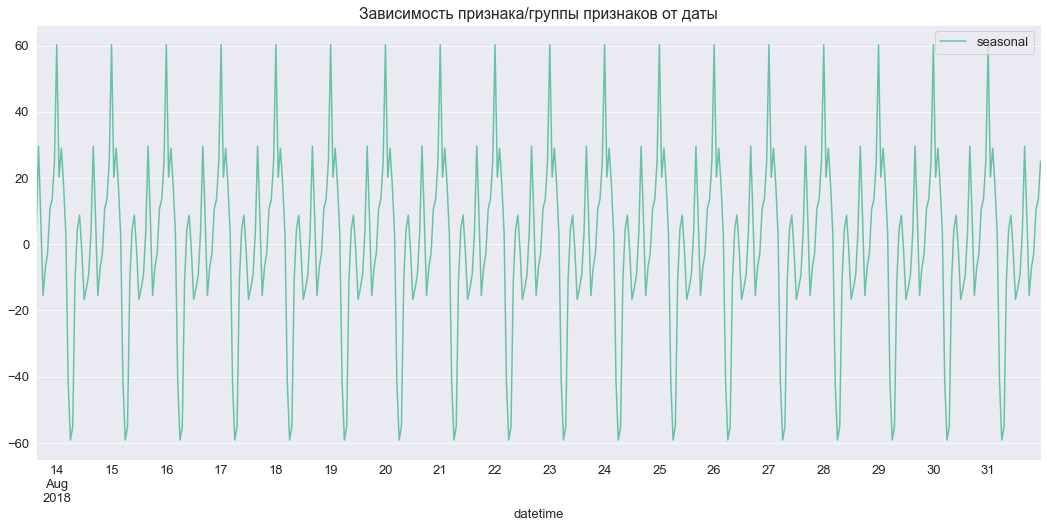

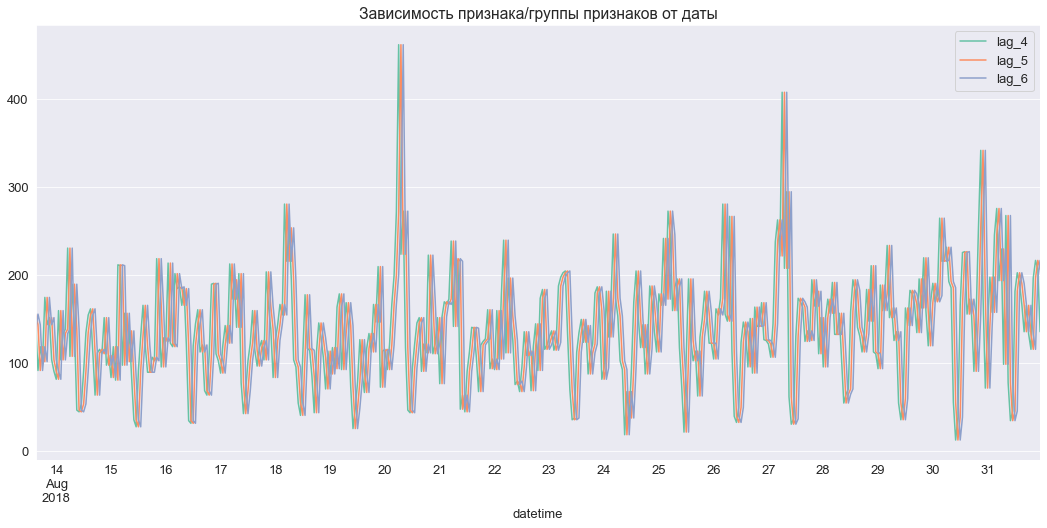

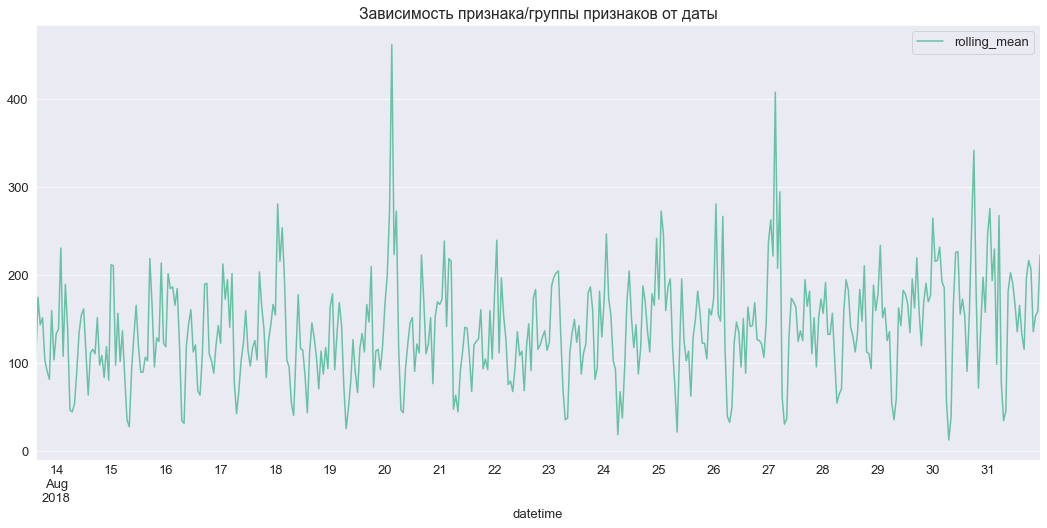

In [85]:
plot_time (test_shap, 'seasonal')
plot_time (test_shap, ['lag_4', 'lag_5', 'lag_6'])
plot_time (test_shap, 'rolling_mean')

<ins>Максимальные ошибки:
- в конце месяца,
- при значениях сезонности ниже средних,
- при отстающих значених немного выше средних,
- при скользящем среднем около 200-270, что выше среднего значения в этом признаке.

#### Зависимость вклада в предсказания модели от каждого признака на точечных диаграммах

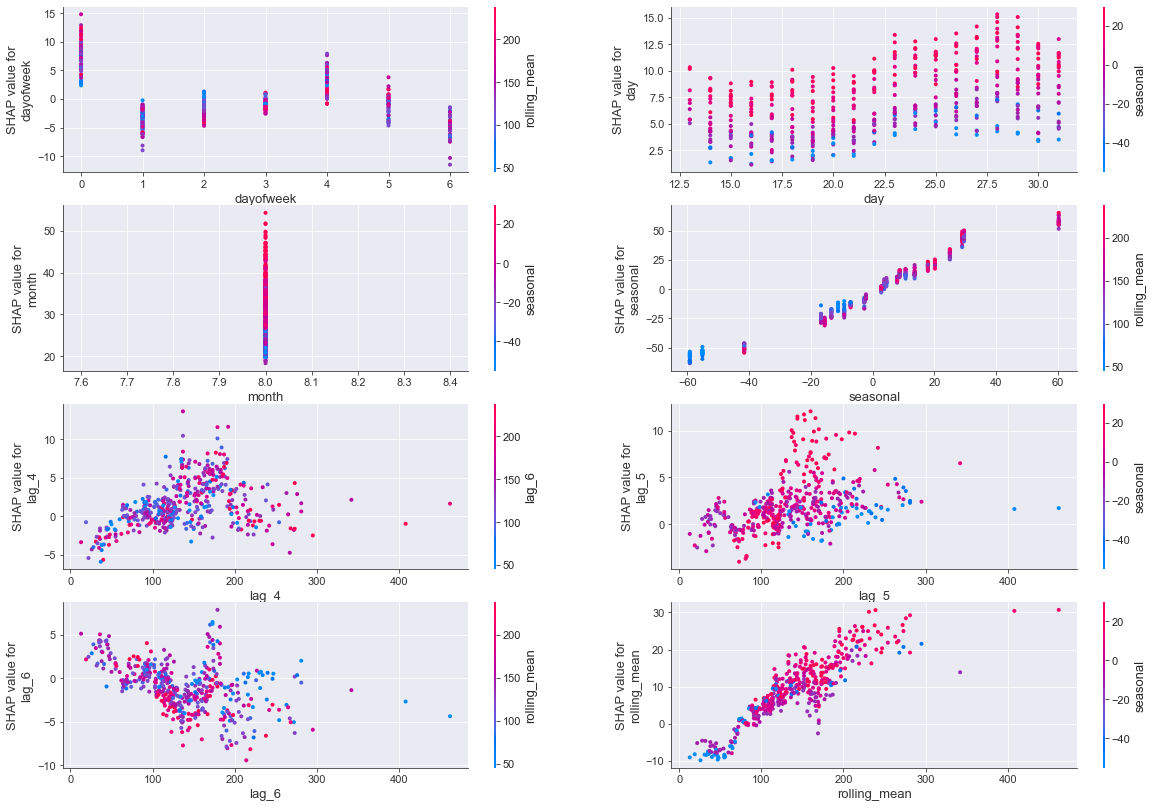

In [86]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 14))
axes = axes.ravel()

for i, col in enumerate(X):
    
    shap.dependence_plot(col,
                         shap_values,
                         features_test_boost,
                         show=False,
                         ax=axes[i])

<ins>Месяц:
- признак завышает вклад
    
<ins>Сезонность:
- признак в равной степени завышает и занижает вклад
- с увеличением значения признака растет завышение вклада
    
<ins>Скользящее среднее:
- признак чаще завышает вклад
- с увеличением значения признака растет завышение вклада
    
<ins>День недели:
- признак чаще занижает вклад
- завышение наблюдается по понедельникам, пятницам и субботам

<ins>День:
- признак завышает вклад
- чем больше значение дня степень завышения колеблется по синосоиде, возможно, это связано с вращением земли.
    
<ins>Отстающее на 4 значения:
- признак чаще завышает вклад
- с увеличением значения признака растет завышение вклада
    
<ins>Отстающее на 5 значения:
- признак чаще завышает вклад
- с увеличением значения признака растет завышение вклада
    
<ins>Отстающее на 6 значения:
- признак чаще занижает вклад
- с увеличением значения признака растет завышение вклада

## Выводы

Для компании «Чётенькое такси»:
- проведено TSA исследование данных,
- данные обработаны для машинного обучения,
- проведено машинное обучение,
- выбрана лучшая по критериям заказчика модель и проверена на тестовой выборке,
- проведена интерпретация результатов машинного обучения.